<a href="https://colab.research.google.com/github/pankajm333/Dual-Perspective-Fusion-Network-for-Aspect-Based-Multimodal-Sentiment-Analysis/blob/main/10ppr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- Cell 1: Mount Google Drive and list the dataset folder ---
from google.colab import drive
import os
from pathlib import Path

# 1) Mount Drive (you will be prompted to authorize)
drive.mount('/content/drive')

# 2) Set the dataset path .

DATA_ROOT = Path("/content/drive/MyDrive/MSA/TwitterDataMABSA")


if not DATA_ROOT.exists():
    print("Provided DATA_ROOT not found at:", DATA_ROOT)
    print("Listing top-level directories in your Drive so you can copy the correct path:")
    for p in sorted(Path("/content/drive/MyDrive").iterdir()):
        print(" ", p.name)
else:
    print("DATA_ROOT found:", DATA_ROOT)

# 4) Show a small tree of the dataset folder (first two levels)
def show_tree(root: Path, max_items=50):
    print("\nContents of:", root)
    if not root.exists():
        print("  (path does not exist)")
        return
    items = sorted(list(root.iterdir()))
    for i, it in enumerate(items):
        if i >= max_items:
            print("  ... (more items omitted)")
            break
        if it.is_dir():
            print("  [DIR] ", it.name)
            # list up to 8 files inside each dir
            sub = sorted(list(it.iterdir()))[:8]
            for s in sub:
                print("     -", s.name)
        else:
            print("  [FILE]", it.name)

show_tree(DATA_ROOT)


Mounted at /content/drive
DATA_ROOT found: /content/drive/MyDrive/MSA/TwitterDataMABSA

Contents of: /content/drive/MyDrive/MSA/TwitterDataMABSA
  [FILE] README.md
  [DIR]  TwitterDataMABSA
     - README.md
     - TwitterDataMABSA
     - caption
     - imgDealFile
     - oriAdj
     - oriAdj17
     - twitter2015
     - twitter2015_images
  [DIR]  caption
     - twitter2015_images.json
     - twitter2017_images.json
  [DIR]  imgDealFile
     - twitter2015_images.pkl
     - twitter2017_images.pkl
  [DIR]  oriAdj
     - dev_ori_adj.pkl
     - test_ori_adj.pkl
     - train_ori_adj.pkl
  [DIR]  oriAdj17
     - dev_ori_adj.pkl
     - test_ori_adj.pkl
     - train_ori_adj.pkl
     - val_ori_adj.pkl
  [DIR]  twitter2015
     - .~lock.train.tsv#
     - deps
     - dev.json
     - dev.tsv
     - dev.txt
     - test.json
     - test.tsv
     - test.txt
  [DIR]  twitter2015_images
     - 0.jpg
     - 1000046.jpg
     - 1000120.jpg
     - 10005.jpg
     - 1001621.jpg
     - 1001683.jpg
     - 10018

In [ ]:
# --- Cell 2: Clone DPFN repo, install dependencies, and link dataset ---

# 1️⃣ Clone the official DPFN code repository from GitHub
!git clone https://github.com/cntian0/DPFN.git /content/DPFN

# 2️⃣ Move into the repo directory
%cd /content/DPFN

# 3️⃣ Install dependencies (PyTorch, Transformers, Timm, SpaCy, etc.)
!pip install torch torchvision torchaudio --quiet
!pip install transformers timm sentencepiece spacy --quiet
!python -m spacy download en_core_web_sm --quiet

# 4️⃣ (Optional) Check if requirements.txt exists in the repo and install it
import os
if os.path.exists("requirements.txt"):
    !pip install -r requirements.txt --quiet
else:
    print("requirements.txt not found — installed core packages manually.")

# 5️⃣ Link your dataset directory to the repo (so code sees it in ./data)
!ln -s /content/drive/MyDrive/MSA/TwitterDataMABSA /content/DPFN/data

# 6️⃣ Verify that data is linked correctly
!ls -R data | head -40


Cloning into '/content/DPFN'...
remote: Enumerating objects: 68, done.
remote: Counting objects: 100% (68/68), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 68 (delta 22), reused 48 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (68/68), 157.71 KiB | 1.29 MiB/s, done.
Resolving deltas: 100% (22/22), done.
/content/DPFN
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 111.9 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
requirements.txt not found — installed core packages manually.
data:
caption
imgDealFile
oriAdj
oriAdj17
README.md
twitter2015
twitter2015_images
twitter2017
twitter2017_images
TwitterDataMABSA

data/caption:
twitter2015_images

In [ ]:
# --- Cell 3A: Inspect twitter2015 train.tsv structure ---

import pandas as pd
from pathlib import Path

file_path = Path("/content/DPFN/data/twitter2015/train.tsv")

# Read first few rows with no headers
df_preview = pd.read_csv(file_path, sep='\t', header=None)
print("Shape:", df_preview.shape)
print("\nFirst 5 rows:")
print(df_preview.head(5))

print("\nColumn count:", len(df_preview.columns))


Shape: (3180, 5)

First 5 rows:
       0         1            2  \
0  index  #1 Label   #2 ImageID   
1      1         2  1860693.jpg   
2      2         1  1860693.jpg   
3      3         1   195984.jpg   
4      4         0   195984.jpg   

                                                   3                     4  
0                                          #3 String             #3 String  
1        RT @ ltsChuckBass : $T$ is everything # MCM            Chuck Bass  
2   RT @ ltsChuckBass : Chuck Bass is everything $T$                 # MCM  
3    $T$ September 7 - - - - Shut Down New York City  Millions For Trayvon  
4  Millions For Trayvon September 7 - - - - Shut ...         New York City  

Column count: 5


In [ ]:
# --- Cell 3D: Robust conversion (handles 4 or 5 columns) ---

import csv, json
from pathlib import Path

base_path = Path("/content/DPFN/data")
datasets = ["twitter2015", "twitter2017"]

def label_to_text(num):
    mapping = {"0": "negative", "1": "neutral", "2": "positive"}
    return mapping.get(str(num).strip(), "neutral")

def convert_tsv_flexible(folder):
    folder_path = base_path / folder
    for split in ["train", "dev", "test"]:
        tsv_file = folder_path / f"{split}.tsv"
        if not tsv_file.exists():
            print(f"⚠️ Skipping {tsv_file} (not found)")
            continue

        data_json = []
        with open(tsv_file, 'r', encoding='utf-8') as f:
            reader = csv.reader(f, delimiter='\t')
            header = next(reader, None)  # skip header line

            for i, row in enumerate(reader):
                if len(row) < 4:
                    continue  # skip malformed lines

                # Handle both 4-column and 5-column cases
                if len(row) == 5:
                    idx, label, image, text, aspect = row
                elif len(row) == 4:
                    # sometimes the 'aspect' is missing; set to empty
                    idx, label, image, text = row
                    aspect = ""
                else:
                    # any longer/shorter rows, try to fit pattern
                    idx = row[0]
                    label = row[1] if len(row) > 1 else "1"
                    image = row[2] if len(row) > 2 else ""
                    text = row[3] if len(row) > 3 else ""
                    aspect = row[4] if len(row) > 4 else ""

                # clean up
                clean_text = str(text).replace("$T$", str(aspect))
                data_json.append({
                    "id": str(idx),
                    "text": clean_text,
                    "aspect": str(aspect),
                    "label": label_to_text(label),
                    "image": str(image)
                })

        out_file = folder_path / f"{split}.json"
        with open(out_file, "w", encoding="utf-8") as f:
            json.dump(data_json, f, ensure_ascii=False, indent=2)
        print(f"✅ Saved {split}.json ({len(data_json)} samples) to {out_file}")

for d in datasets:
    convert_tsv_flexible(d)


✅ Saved train.json (3179 samples) to /content/DPFN/data/twitter2015/train.json
✅ Saved dev.json (1122 samples) to /content/DPFN/data/twitter2015/dev.json
✅ Saved test.json (1037 samples) to /content/DPFN/data/twitter2015/test.json
✅ Saved train.json (3562 samples) to /content/DPFN/data/twitter2017/train.json
✅ Saved dev.json (1176 samples) to /content/DPFN/data/twitter2017/dev.json
✅ Saved test.json (1234 samples) to /content/DPFN/data/twitter2017/test.json


In [ ]:
!pip install torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.7 MB/s eta 0:00:00


In [ ]:
# --- Cell 4 (improved): Extract ViT image features with checkpoint/resume ---

from pathlib import Path
import torch
from torchvision import transforms
from PIL import Image
import timm
from tqdm import tqdm
import os

# Paths
base_path = Path("/content/DPFN/data")
datasets = ["twitter2015", "twitter2017"]

# 1️⃣ Load pretrained ViT model
model = timm.create_model('vit_base_patch16_224', pretrained=True)
model.eval()
if torch.cuda.is_available():
    model = model.cuda()
print("✅ ViT model loaded and ready.")

# 2️⃣ Define preprocessing transforms (match ViT training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# 3️⃣ Function with checkpoint/resume logic
def extract_vit_features(dataset_name, save_every=100):
    img_dir = base_path / f"{dataset_name}_images"
    out_file = base_path / dataset_name / "vit_feats.pt"

    # --- Load existing checkpoint if present
    if out_file.exists():
        print(f"🟢 Loading existing checkpoint from {out_file}")
        all_features = torch.load(out_file)
        processed = set(all_features.keys())
        print(f"✅ {len(processed)} images already processed — will skip them.")
    else:
        all_features, processed = {}, set()

    img_files = sorted([p for p in img_dir.glob("*.jpg")])
    print(f"🔍 Found {len(img_files)} images for {dataset_name}")

    new_count = 0
    for img_path in tqdm(img_files):
        if img_path.name in processed:
            continue  # skip already done
        try:
            img = Image.open(img_path).convert("RGB")
            tensor = transform(img).unsqueeze(0)
            if torch.cuda.is_available():
                tensor = tensor.cuda()
            with torch.no_grad():
                feat = model.forward_features(tensor)
                feat = feat.mean(dim=1).squeeze().cpu()
            all_features[img_path.name] = feat
            new_count += 1
        except Exception as e:
            print(f"⚠️ Skipping {img_path.name}: {e}")
            continue

        # --- Save checkpoint every N new images
        if new_count % save_every == 0:
            torch.save(all_features, out_file)
            print(f"💾 Checkpoint saved ({len(all_features)} features so far)")

    # --- Final save
    torch.save(all_features, out_file)
    print(f"✅ Finished {dataset_name}: total {len(all_features)} features saved to {out_file}")

# 4️⃣ Run for both datasets
for d in datasets:
    extract_vit_features(d, save_every=100)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

✅ ViT model loaded and ready.
🟢 Loading existing checkpoint from /content/DPFN/data/twitter2015/vit_feats.pt
✅ 8288 images already processed — will skip them.
🔍 Found 8288 images for twitter2015


100%|██████████| 8288/8288 [00:00<00:00, 1325695.66it/s]


✅ Finished twitter2015: total 8288 features saved to /content/DPFN/data/twitter2015/vit_feats.pt
🟢 Loading existing checkpoint from /content/DPFN/data/twitter2017/vit_feats.pt
✅ 4461 images already processed — will skip them.
🔍 Found 4819 images for twitter2017


 60%|█████▉    | 2886/4819 [00:00<00:00, 12301.86it/s]

⚠️ Skipping O_1004.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1004.jpg'
⚠️ Skipping O_1019.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1019.jpg'
⚠️ Skipping O_1039.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1039.jpg'
⚠️ Skipping O_1057.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1057.jpg'
⚠️ Skipping O_1079.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1079.jpg'
⚠️ Skipping O_1116.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1116.jpg'
⚠️ Skipping O_112.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_112.jpg'
⚠️ Skipping O_1123.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1123.jpg'
⚠️ Skipping O_1132.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1132.jpg'
⚠️ Skipping O_116.jpg: cannot identify image file '/content/DPFN/data/twitter2017_im

 66%|██████▌   | 3177/4819 [00:23<00:16, 98.65it/s]   

⚠️ Skipping O_158.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_158.jpg'


 66%|██████▌   | 3182/4819 [00:31<00:24, 65.81it/s]

⚠️ Skipping O_1591.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1591.jpg'


 66%|██████▌   | 3183/4819 [01:07<01:16, 21.43it/s]

⚠️ Skipping O_1592.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1592.jpg'


 66%|██████▌   | 3185/4819 [01:13<01:28, 18.38it/s]

⚠️ Skipping O_1597.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1597.jpg'
⚠️ Skipping O_16.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_16.jpg'


 67%|██████▋   | 3210/4819 [01:44<02:45,  9.75it/s]

⚠️ Skipping O_1618.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1618.jpg'
⚠️ Skipping O_1622.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1622.jpg'
⚠️ Skipping O_1629.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1629.jpg'
⚠️ Skipping O_1631.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1631.jpg'
⚠️ Skipping O_1636.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1636.jpg'
⚠️ Skipping O_1637.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1637.jpg'
⚠️ Skipping O_1638.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1638.jpg'
⚠️ Skipping O_1651.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1651.jpg'
⚠️ Skipping O_1655.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1655.jpg'
⚠️ Skipping O_166.jpg: cannot identify image file '/content/DPFN/data/twitter2017_

 70%|███████   | 3383/4819 [01:44<01:33, 15.35it/s]

⚠️ Skipping O_1818.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1818.jpg'
⚠️ Skipping O_1832.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1832.jpg'
⚠️ Skipping O_1843.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1843.jpg'
⚠️ Skipping O_185.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_185.jpg'
⚠️ Skipping O_1855.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1855.jpg'
⚠️ Skipping O_1867.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1867.jpg'
⚠️ Skipping O_1925.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1925.jpg'
⚠️ Skipping O_193.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_193.jpg'
⚠️ Skipping O_1957.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_1957.jpg'
⚠️ Skipping O_1975.jpg: cannot identify image file '/content/DPFN/data/twitter2017_ima

 75%|███████▌  | 3622/4819 [01:44<00:42, 28.45it/s]

⚠️ Skipping O_2289.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2289.jpg'
⚠️ Skipping O_2300.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2300.jpg'
⚠️ Skipping O_2306.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2306.jpg'
⚠️ Skipping O_2315.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2315.jpg'
⚠️ Skipping O_2333.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2333.jpg'
⚠️ Skipping O_2340.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2340.jpg'
⚠️ Skipping O_2343.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2343.jpg'
⚠️ Skipping O_2345.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2345.jpg'
⚠️ Skipping O_2347.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2347.jpg'
⚠️ Skipping O_2348.jpg: cannot identify image file '/content/DPFN/data/twitter2017

 77%|███████▋  | 3720/4819 [01:44<00:29, 37.31it/s]

⚠️ Skipping O_2575.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2575.jpg'
⚠️ Skipping O_2576.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2576.jpg'
⚠️ Skipping O_2589.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2589.jpg'
⚠️ Skipping O_2590.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2590.jpg'
⚠️ Skipping O_2601.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2601.jpg'
⚠️ Skipping O_2603.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2603.jpg'
⚠️ Skipping O_2622.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2622.jpg'
⚠️ Skipping O_2625.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2625.jpg'
⚠️ Skipping O_2633.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_2633.jpg'
⚠️ Skipping O_2644.jpg: cannot identify image file '/content/DPFN/data/twitter2017

 84%|████████▍ | 4072/4819 [01:45<00:08, 91.44it/s]

⚠️ Skipping O_3112.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_3112.jpg'
⚠️ Skipping O_3130.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_3130.jpg'
⚠️ Skipping O_3143.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_3143.jpg'
⚠️ Skipping O_3167.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_3167.jpg'
⚠️ Skipping O_3173.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_3173.jpg'
⚠️ Skipping O_3178.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_3178.jpg'
⚠️ Skipping O_3186.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_3186.jpg'
⚠️ Skipping O_3190.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_3190.jpg'
⚠️ Skipping O_3192.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_3192.jpg'
⚠️ Skipping O_321.jpg: cannot identify image file '/content/DPFN/data/twitter2017_

 87%|████████▋ | 4206/4819 [01:45<00:05, 120.58it/s]

⚠️ Skipping O_3712.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_3712.jpg'
⚠️ Skipping O_3713.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_3713.jpg'
⚠️ Skipping O_3723.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_3723.jpg'
⚠️ Skipping O_3735.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_3735.jpg'
⚠️ Skipping O_3740.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_3740.jpg'
⚠️ Skipping O_3752.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_3752.jpg'
⚠️ Skipping O_3781.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_3781.jpg'
⚠️ Skipping O_3790.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_3790.jpg'
⚠️ Skipping O_3793.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_3793.jpg'
⚠️ Skipping O_381.jpg: cannot identify image file '/content/DPFN/data/twitter2017_

 90%|████████▉ | 4320/4819 [01:45<00:03, 154.08it/s]

⚠️ Skipping O_4144.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4144.jpg'
⚠️ Skipping O_4155.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4155.jpg'
⚠️ Skipping O_4179.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4179.jpg'
⚠️ Skipping O_4180.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4180.jpg'
⚠️ Skipping O_4189.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4189.jpg'
⚠️ Skipping O_4213.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4213.jpg'
⚠️ Skipping O_4223.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4223.jpg'
⚠️ Skipping O_4224.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4224.jpg'
⚠️ Skipping O_4225.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4225.jpg'
⚠️ Skipping O_423.jpg: cannot identify image file '/content/DPFN/data/twitter2017_

 92%|█████████▏| 4425/4819 [01:45<00:02, 186.99it/s]

⚠️ Skipping O_4404.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4404.jpg'
⚠️ Skipping O_4459.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4459.jpg'
⚠️ Skipping O_4514.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4514.jpg'
⚠️ Skipping O_4524.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4524.jpg'
⚠️ Skipping O_4525.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4525.jpg'
⚠️ Skipping O_456.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_456.jpg'
⚠️ Skipping O_4561.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4561.jpg'
⚠️ Skipping O_4571.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4571.jpg'
⚠️ Skipping O_4589.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4589.jpg'


100%|██████████| 4819/4819 [01:46<00:00, 45.43it/s] 

⚠️ Skipping O_4605.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4605.jpg'
⚠️ Skipping O_4644.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4644.jpg'
⚠️ Skipping O_4670.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4670.jpg'
⚠️ Skipping O_4677.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4677.jpg'
⚠️ Skipping O_4678.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4678.jpg'
⚠️ Skipping O_468.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_468.jpg'
⚠️ Skipping O_4690.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4690.jpg'
⚠️ Skipping O_470.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_470.jpg'
⚠️ Skipping O_4714.jpg: cannot identify image file '/content/DPFN/data/twitter2017_images/O_4714.jpg'
⚠️ Skipping O_4718.jpg: cannot identify image file '/content/DPFN/data/twitter2017_ima

✅ Finished twitter2017: total 4461 features saved to /content/DPFN/data/twitter2017/vit_feats.pt


In [ ]:
# --- Cell 5: Generate dependency adjacency graphs for text (syntax) ---

import spacy
import json
from pathlib import Path
from tqdm import tqdm
import numpy as np

# Load spaCy English model (we already downloaded it earlier)
nlp = spacy.load("en_core_web_sm")

# Base path to datasets
base_path = Path("/content/DPFN/data")
datasets = ["twitter2015", "twitter2017"]

def build_dependency_graph(text):
    """
    Create a soft adjacency matrix (A_ij = 1 if word i depends on j or vice versa).
    """
    doc = nlp(text)
    n = len(doc)
    if n == 0:
        return np.zeros((1, 1)).tolist()

    adj = np.zeros((n, n))
    for token in doc:
        adj[token.i][token.i] = 1  # self-loop
        for child in token.children:
            adj[token.i][child.i] = 1
            adj[child.i][token.i] = 1
    return adj.tolist()

def process_dataset(dataset_name):
    ds_path = base_path / dataset_name
    out_dir = ds_path / "deps"
    out_dir.mkdir(exist_ok=True)
    print(f"\n🔍 Building dependency graphs for {dataset_name} ...")

    for split in ["train", "dev", "test"]:
        in_file = ds_path / f"{split}.json"
        if not in_file.exists():
            print(f"⚠️ Skipping {in_file} (not found)")
            continue

        with open(in_file, "r", encoding="utf-8") as f:
            data = json.load(f)

        graphs = []
        for item in tqdm(data, desc=f"{dataset_name}-{split}"):
            text = item["text"]
            adj = build_dependency_graph(text)
            graphs.append(adj)

        out_file = out_dir / f"{split}_deps.json"
        with open(out_file, "w", encoding="utf-8") as f:
            json.dump(graphs, f)
        print(f"✅ Saved {split}_deps.json with {len(graphs)} graphs")

for d in datasets:
    process_dataset(d)

print("\n✅ All dependency graphs created successfully!")



🔍 Building dependency graphs for twitter2015 ...


twitter2015-train: 100%|██████████| 3179/3179 [00:23<00:00, 136.14it/s]


✅ Saved train_deps.json with 3179 graphs


twitter2015-dev: 100%|██████████| 1122/1122 [00:07<00:00, 157.42it/s]


✅ Saved dev_deps.json with 1122 graphs


twitter2015-test: 100%|██████████| 1037/1037 [00:08<00:00, 127.72it/s]


✅ Saved test_deps.json with 1037 graphs

🔍 Building dependency graphs for twitter2017 ...


twitter2017-train: 100%|██████████| 3562/3562 [00:24<00:00, 143.54it/s]


✅ Saved train_deps.json with 3562 graphs


twitter2017-dev: 100%|██████████| 1176/1176 [00:06<00:00, 169.14it/s]


✅ Saved dev_deps.json with 1176 graphs


twitter2017-test: 100%|██████████| 1234/1234 [00:08<00:00, 150.13it/s]


✅ Saved test_deps.json with 1234 graphs

✅ All dependency graphs created successfully!


In [ ]:
# 🔍 Extract ViT image features for Twitter15 & Twitter17 datasets
# This step creates vit_feats.pt files in their respective data folders.

import torch
from transformers import ViTModel, ViTImageProcessor
from PIL import Image
import os
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize the ViT model (same as paper: ViT-B/16 pretrained on ImageNet)
processor = ViTImageProcessor.from_pretrained("google/vit-base-patch16-224")
model = ViTModel.from_pretrained("google/vit-base-patch16-224").to(device)
model.eval()

def extract_vit_features(image_dir, output_path):
    all_feats = {}
    for img_name in tqdm(os.listdir(image_dir), desc=f"Extracting from {image_dir}"):
        if not img_name.lower().endswith((".jpg", ".png", ".jpeg")):
            continue
        img_path = os.path.join(image_dir, img_name)
        try:
            image = Image.open(img_path).convert("RGB")
            inputs = processor(images=image, return_tensors="pt").to(device)
            with torch.no_grad():
                outputs = model(**inputs)
                feat = outputs.last_hidden_state.mean(dim=1).squeeze().cpu()
            all_feats[img_name] = feat
        except Exception as e:
            print(f"⚠️ Skipping {img_name}: {e}")
    torch.save(all_feats, output_path)
    print(f"✅ Saved ViT features → {output_path}")

# Twitter15
extract_vit_features(
    "data/twitter2015_images",
    "data/twitter2015/vit_feats.pt"
)

# Twitter17
extract_vit_features(
    "data/twitter2017_images",
    "data/twitter2017/vit_feats.pt"
)

print("🎯 All visual features extracted successfully!")


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Extracting from data/twitter2015_images: 100%|██████████| 8288/8288 [07:42<00:00, 17.93it/s]


✅ Saved ViT features → data/twitter2015/vit_feats.pt


Extracting from data/twitter2017_images:   0%|          | 0/4819 [00:00<?, ?it/s]

⚠️ Skipping O_2959.jpg: cannot identify image file 'data/twitter2017_images/O_2959.jpg'


Extracting from data/twitter2017_images:   0%|          | 10/4819 [00:00<04:13, 19.01it/s]

⚠️ Skipping O_2905.jpg: cannot identify image file 'data/twitter2017_images/O_2905.jpg'
⚠️ Skipping O_2903.jpg: cannot identify image file 'data/twitter2017_images/O_2903.jpg'


Extracting from data/twitter2017_images:   1%|          | 28/4819 [00:00<01:55, 41.41it/s]

⚠️ Skipping O_3014.jpg: cannot identify image file 'data/twitter2017_images/O_3014.jpg'
⚠️ Skipping O_2821.jpg: cannot identify image file 'data/twitter2017_images/O_2821.jpg'
⚠️ Skipping O_290.jpg: cannot identify image file 'data/twitter2017_images/O_290.jpg'
⚠️ Skipping O_30.jpg: cannot identify image file 'data/twitter2017_images/O_30.jpg'


Extracting from data/twitter2017_images:   1%|          | 41/4819 [00:01<01:51, 42.92it/s]

⚠️ Skipping O_2890.jpg: cannot identify image file 'data/twitter2017_images/O_2890.jpg'
⚠️ Skipping O_2812.jpg: cannot identify image file 'data/twitter2017_images/O_2812.jpg'
⚠️ Skipping O_3065.jpg: cannot identify image file 'data/twitter2017_images/O_3065.jpg'
⚠️ Skipping O_295.jpg: cannot identify image file 'data/twitter2017_images/O_295.jpg'


Extracting from data/twitter2017_images:   1%|          | 52/4819 [00:30<2:08:04,  1.61s/it]

⚠️ Skipping O_2902.jpg: cannot identify image file 'data/twitter2017_images/O_2902.jpg'


Extracting from data/twitter2017_images:   1%|▏         | 62/4819 [00:35<1:03:10,  1.26it/s]

⚠️ Skipping O_2970.jpg: cannot identify image file 'data/twitter2017_images/O_2970.jpg'


Extracting from data/twitter2017_images:   1%|▏         | 70/4819 [00:35<30:10,  2.62it/s]

⚠️ Skipping O_2889.jpg: cannot identify image file 'data/twitter2017_images/O_2889.jpg'


Extracting from data/twitter2017_images:   2%|▏         | 79/4819 [00:35<14:27,  5.46it/s]

⚠️ Skipping O_2969.jpg: cannot identify image file 'data/twitter2017_images/O_2969.jpg'
⚠️ Skipping O_2955.jpg: cannot identify image file 'data/twitter2017_images/O_2955.jpg'
⚠️ Skipping O_2980.jpg: cannot identify image file 'data/twitter2017_images/O_2980.jpg'
⚠️ Skipping O_2879.jpg: cannot identify image file 'data/twitter2017_images/O_2879.jpg'


Extracting from data/twitter2017_images:   2%|▏         | 92/4819 [00:35<06:22, 12.36it/s]

⚠️ Skipping O_321.jpg: cannot identify image file 'data/twitter2017_images/O_321.jpg'
⚠️ Skipping O_3226.jpg: cannot identify image file 'data/twitter2017_images/O_3226.jpg'


Extracting from data/twitter2017_images:   2%|▏         | 102/4819 [00:36<03:52, 20.31it/s]

⚠️ Skipping O_3167.jpg: cannot identify image file 'data/twitter2017_images/O_3167.jpg'


Extracting from data/twitter2017_images:   2%|▏         | 113/4819 [00:36<02:54, 26.95it/s]

⚠️ Skipping O_3426.jpg: cannot identify image file 'data/twitter2017_images/O_3426.jpg'
⚠️ Skipping O_3143.jpg: cannot identify image file 'data/twitter2017_images/O_3143.jpg'
⚠️ Skipping O_3418.jpg: cannot identify image file 'data/twitter2017_images/O_3418.jpg'


Extracting from data/twitter2017_images:   3%|▎         | 124/4819 [00:36<02:17, 34.21it/s]

⚠️ Skipping O_3173.jpg: cannot identify image file 'data/twitter2017_images/O_3173.jpg'
⚠️ Skipping O_3296.jpg: cannot identify image file 'data/twitter2017_images/O_3296.jpg'


Extracting from data/twitter2017_images:   3%|▎         | 148/4819 [00:37<02:05, 37.35it/s]

⚠️ Skipping O_3407.jpg: cannot identify image file 'data/twitter2017_images/O_3407.jpg'


Extracting from data/twitter2017_images:   4%|▎         | 175/4819 [00:38<01:36, 48.28it/s]

⚠️ Skipping O_3397.jpg: cannot identify image file 'data/twitter2017_images/O_3397.jpg'
⚠️ Skipping O_3190.jpg: cannot identify image file 'data/twitter2017_images/O_3190.jpg'
⚠️ Skipping O_3255.jpg: cannot identify image file 'data/twitter2017_images/O_3255.jpg'
⚠️ Skipping O_3186.jpg: cannot identify image file 'data/twitter2017_images/O_3186.jpg'


Extracting from data/twitter2017_images:   4%|▍         | 196/4819 [00:38<01:37, 47.29it/s]

⚠️ Skipping O_3192.jpg: cannot identify image file 'data/twitter2017_images/O_3192.jpg'
⚠️ Skipping O_3353.jpg: cannot identify image file 'data/twitter2017_images/O_3353.jpg'
⚠️ Skipping O_3178.jpg: cannot identify image file 'data/twitter2017_images/O_3178.jpg'


Extracting from data/twitter2017_images:   4%|▍         | 210/4819 [00:38<01:27, 52.74it/s]

⚠️ Skipping O_3322.jpg: cannot identify image file 'data/twitter2017_images/O_3322.jpg'
⚠️ Skipping O_3130.jpg: cannot identify image file 'data/twitter2017_images/O_3130.jpg'
⚠️ Skipping O_331.jpg: cannot identify image file 'data/twitter2017_images/O_331.jpg'
⚠️ Skipping O_3314.jpg: cannot identify image file 'data/twitter2017_images/O_3314.jpg'


Extracting from data/twitter2017_images:   5%|▍         | 235/4819 [00:39<01:33, 49.21it/s]

⚠️ Skipping O_3460.jpg: cannot identify image file 'data/twitter2017_images/O_3460.jpg'
⚠️ Skipping O_3711.jpg: cannot identify image file 'data/twitter2017_images/O_3711.jpg'
⚠️ Skipping O_3810.jpg: cannot identify image file 'data/twitter2017_images/O_3810.jpg'


Extracting from data/twitter2017_images:   5%|▍         | 240/4819 [00:39<01:37, 47.07it/s]

⚠️ Skipping O_3567.jpg: cannot identify image file 'data/twitter2017_images/O_3567.jpg'
⚠️ Skipping O_3579.jpg: cannot identify image file 'data/twitter2017_images/O_3579.jpg'


Extracting from data/twitter2017_images:   5%|▌         | 256/4819 [00:39<01:43, 44.26it/s]

⚠️ Skipping O_352.jpg: cannot identify image file 'data/twitter2017_images/O_352.jpg'
⚠️ Skipping O_3793.jpg: cannot identify image file 'data/twitter2017_images/O_3793.jpg'


Extracting from data/twitter2017_images:   6%|▌         | 268/4819 [00:39<01:33, 48.60it/s]

⚠️ Skipping O_3523.jpg: cannot identify image file 'data/twitter2017_images/O_3523.jpg'
⚠️ Skipping O_3540.jpg: cannot identify image file 'data/twitter2017_images/O_3540.jpg'


Extracting from data/twitter2017_images:   6%|▌         | 279/4819 [00:40<01:32, 49.25it/s]

⚠️ Skipping O_3740.jpg: cannot identify image file 'data/twitter2017_images/O_3740.jpg'
⚠️ Skipping O_3545.jpg: cannot identify image file 'data/twitter2017_images/O_3545.jpg'
⚠️ Skipping O_3576.jpg: cannot identify image file 'data/twitter2017_images/O_3576.jpg'
⚠️ Skipping O_3752.jpg: cannot identify image file 'data/twitter2017_images/O_3752.jpg'


Extracting from data/twitter2017_images:   6%|▌         | 292/4819 [00:40<01:23, 54.53it/s]

⚠️ Skipping O_3508.jpg: cannot identify image file 'data/twitter2017_images/O_3508.jpg'
⚠️ Skipping O_3712.jpg: cannot identify image file 'data/twitter2017_images/O_3712.jpg'


Extracting from data/twitter2017_images:   6%|▋         | 304/4819 [00:40<01:33, 48.29it/s]

⚠️ Skipping O_3501.jpg: cannot identify image file 'data/twitter2017_images/O_3501.jpg'


Extracting from data/twitter2017_images:   7%|▋         | 314/4819 [00:40<01:40, 44.97it/s]

⚠️ Skipping O_348.jpg: cannot identify image file 'data/twitter2017_images/O_348.jpg'
⚠️ Skipping O_3487.jpg: cannot identify image file 'data/twitter2017_images/O_3487.jpg'


Extracting from data/twitter2017_images:   7%|▋         | 329/4819 [00:41<01:41, 44.33it/s]

⚠️ Skipping O_3735.jpg: cannot identify image file 'data/twitter2017_images/O_3735.jpg'
⚠️ Skipping O_3495.jpg: cannot identify image file 'data/twitter2017_images/O_3495.jpg'


Extracting from data/twitter2017_images:   7%|▋         | 352/4819 [00:41<01:28, 50.52it/s]

⚠️ Skipping O_3655.jpg: cannot identify image file 'data/twitter2017_images/O_3655.jpg'
⚠️ Skipping O_3781.jpg: cannot identify image file 'data/twitter2017_images/O_3781.jpg'
⚠️ Skipping O_3723.jpg: cannot identify image file 'data/twitter2017_images/O_3723.jpg'


Extracting from data/twitter2017_images:   8%|▊         | 365/4819 [00:41<01:21, 54.62it/s]

⚠️ Skipping O_3790.jpg: cannot identify image file 'data/twitter2017_images/O_3790.jpg'
⚠️ Skipping O_3531.jpg: cannot identify image file 'data/twitter2017_images/O_3531.jpg'
⚠️ Skipping O_3470.jpg: cannot identify image file 'data/twitter2017_images/O_3470.jpg'
⚠️ Skipping O_3713.jpg: cannot identify image file 'data/twitter2017_images/O_3713.jpg'
⚠️ Skipping O_381.jpg: cannot identify image file 'data/twitter2017_images/O_381.jpg'
⚠️ Skipping O_3569.jpg: cannot identify image file 'data/twitter2017_images/O_3569.jpg'


Extracting from data/twitter2017_images:   8%|▊         | 384/4819 [00:42<01:20, 54.87it/s]

⚠️ Skipping O_3988.jpg: cannot identify image file 'data/twitter2017_images/O_3988.jpg'
⚠️ Skipping O_39.jpg: cannot identify image file 'data/twitter2017_images/O_39.jpg'


Extracting from data/twitter2017_images:   8%|▊         | 401/4819 [00:42<01:32, 47.53it/s]

⚠️ Skipping O_382.jpg: cannot identify image file 'data/twitter2017_images/O_382.jpg'
⚠️ Skipping O_4126.jpg: cannot identify image file 'data/twitter2017_images/O_4126.jpg'


Extracting from data/twitter2017_images:   9%|▊         | 412/4819 [00:43<02:26, 30.11it/s]

⚠️ Skipping O_4155.jpg: cannot identify image file 'data/twitter2017_images/O_4155.jpg'
⚠️ Skipping O_4094.jpg: cannot identify image file 'data/twitter2017_images/O_4094.jpg'


Extracting from data/twitter2017_images:   9%|▉         | 424/4819 [00:43<01:53, 38.78it/s]

⚠️ Skipping O_4060.jpg: cannot identify image file 'data/twitter2017_images/O_4060.jpg'
⚠️ Skipping O_3984.jpg: cannot identify image file 'data/twitter2017_images/O_3984.jpg'
⚠️ Skipping O_4095.jpg: cannot identify image file 'data/twitter2017_images/O_4095.jpg'


Extracting from data/twitter2017_images:   9%|▉         | 440/4819 [00:43<01:22, 53.19it/s]

⚠️ Skipping O_3971.jpg: cannot identify image file 'data/twitter2017_images/O_3971.jpg'
⚠️ Skipping O_4180.jpg: cannot identify image file 'data/twitter2017_images/O_4180.jpg'
⚠️ Skipping O_4179.jpg: cannot identify image file 'data/twitter2017_images/O_4179.jpg'
⚠️ Skipping O_3936.jpg: cannot identify image file 'data/twitter2017_images/O_3936.jpg'
⚠️ Skipping O_4080.jpg: cannot identify image file 'data/twitter2017_images/O_4080.jpg'
⚠️ Skipping O_3955.jpg: cannot identify image file 'data/twitter2017_images/O_3955.jpg'


Extracting from data/twitter2017_images:  10%|▉         | 458/4819 [00:44<01:26, 50.20it/s]

⚠️ Skipping O_4119.jpg: cannot identify image file 'data/twitter2017_images/O_4119.jpg'
⚠️ Skipping O_3977.jpg: cannot identify image file 'data/twitter2017_images/O_3977.jpg'


Extracting from data/twitter2017_images:  10%|█         | 486/4819 [00:44<01:28, 49.14it/s]

⚠️ Skipping O_400.jpg: cannot identify image file 'data/twitter2017_images/O_400.jpg'
⚠️ Skipping O_4144.jpg: cannot identify image file 'data/twitter2017_images/O_4144.jpg'
⚠️ Skipping O_399.jpg: cannot identify image file 'data/twitter2017_images/O_399.jpg'


Extracting from data/twitter2017_images:  10%|█         | 502/4819 [00:45<01:31, 47.09it/s]

⚠️ Skipping O_4031.jpg: cannot identify image file 'data/twitter2017_images/O_4031.jpg'
⚠️ Skipping O_4005.jpg: cannot identify image file 'data/twitter2017_images/O_4005.jpg'
⚠️ Skipping O_3987.jpg: cannot identify image file 'data/twitter2017_images/O_3987.jpg'


Extracting from data/twitter2017_images:  11%|█         | 522/4819 [00:45<01:17, 55.49it/s]

⚠️ Skipping O_4057.jpg: cannot identify image file 'data/twitter2017_images/O_4057.jpg'
⚠️ Skipping O_3991.jpg: cannot identify image file 'data/twitter2017_images/O_3991.jpg'
⚠️ Skipping O_4039.jpg: cannot identify image file 'data/twitter2017_images/O_4039.jpg'
⚠️ Skipping O_4514.jpg: cannot identify image file 'data/twitter2017_images/O_4514.jpg'
⚠️ Skipping O_4317.jpg: cannot identify image file 'data/twitter2017_images/O_4317.jpg'


Extracting from data/twitter2017_images:  11%|█         | 534/4819 [00:45<01:24, 50.56it/s]

⚠️ Skipping O_4213.jpg: cannot identify image file 'data/twitter2017_images/O_4213.jpg'
⚠️ Skipping O_4459.jpg: cannot identify image file 'data/twitter2017_images/O_4459.jpg'
⚠️ Skipping O_4332.jpg: cannot identify image file 'data/twitter2017_images/O_4332.jpg'
⚠️ Skipping O_4402.jpg: cannot identify image file 'data/twitter2017_images/O_4402.jpg'


Extracting from data/twitter2017_images:  12%|█▏        | 555/4819 [00:46<01:38, 43.18it/s]

⚠️ Skipping O_4224.jpg: cannot identify image file 'data/twitter2017_images/O_4224.jpg'


Extracting from data/twitter2017_images:  12%|█▏        | 566/4819 [00:46<01:31, 46.45it/s]

⚠️ Skipping O_4525.jpg: cannot identify image file 'data/twitter2017_images/O_4525.jpg'
⚠️ Skipping O_4397.jpg: cannot identify image file 'data/twitter2017_images/O_4397.jpg'


Extracting from data/twitter2017_images:  12%|█▏        | 591/4819 [00:47<01:41, 41.76it/s]

⚠️ Skipping O_456.jpg: cannot identify image file 'data/twitter2017_images/O_456.jpg'


Extracting from data/twitter2017_images:  12%|█▏        | 597/4819 [00:47<01:37, 43.21it/s]

⚠️ Skipping O_4223.jpg: cannot identify image file 'data/twitter2017_images/O_4223.jpg'


Extracting from data/twitter2017_images:  13%|█▎        | 612/4819 [00:47<01:43, 40.52it/s]

⚠️ Skipping O_4305.jpg: cannot identify image file 'data/twitter2017_images/O_4305.jpg'
⚠️ Skipping O_4404.jpg: cannot identify image file 'data/twitter2017_images/O_4404.jpg'
⚠️ Skipping O_438.jpg: cannot identify image file 'data/twitter2017_images/O_438.jpg'


Extracting from data/twitter2017_images:  13%|█▎        | 622/4819 [00:47<01:42, 40.76it/s]

⚠️ Skipping O_4315.jpg: cannot identify image file 'data/twitter2017_images/O_4315.jpg'
⚠️ Skipping O_4354.jpg: cannot identify image file 'data/twitter2017_images/O_4354.jpg'


Extracting from data/twitter2017_images:  13%|█▎        | 637/4819 [00:48<01:41, 41.07it/s]

⚠️ Skipping O_4299.jpg: cannot identify image file 'data/twitter2017_images/O_4299.jpg'
⚠️ Skipping O_4280.jpg: cannot identify image file 'data/twitter2017_images/O_4280.jpg'
⚠️ Skipping O_4189.jpg: cannot identify image file 'data/twitter2017_images/O_4189.jpg'
⚠️ Skipping O_4240.jpg: cannot identify image file 'data/twitter2017_images/O_4240.jpg'


Extracting from data/twitter2017_images:  13%|█▎        | 650/4819 [00:48<02:39, 26.19it/s]

⚠️ Skipping O_4225.jpg: cannot identify image file 'data/twitter2017_images/O_4225.jpg'
⚠️ Skipping O_4251.jpg: cannot identify image file 'data/twitter2017_images/O_4251.jpg'


Extracting from data/twitter2017_images:  14%|█▎        | 662/4819 [00:49<03:38, 19.03it/s]

⚠️ Skipping O_423.jpg: cannot identify image file 'data/twitter2017_images/O_423.jpg'
⚠️ Skipping O_4524.jpg: cannot identify image file 'data/twitter2017_images/O_4524.jpg'


Extracting from data/twitter2017_images:  14%|█▍        | 677/4819 [00:49<02:04, 33.21it/s]

⚠️ Skipping O_4670.jpg: cannot identify image file 'data/twitter2017_images/O_4670.jpg'
⚠️ Skipping O_473.jpg: cannot identify image file 'data/twitter2017_images/O_473.jpg'
⚠️ Skipping O_4879.jpg: cannot identify image file 'data/twitter2017_images/O_4879.jpg'
⚠️ Skipping O_470.jpg: cannot identify image file 'data/twitter2017_images/O_470.jpg'
⚠️ Skipping O_4678.jpg: cannot identify image file 'data/twitter2017_images/O_4678.jpg'


Extracting from data/twitter2017_images:  14%|█▍        | 687/4819 [00:50<01:56, 35.61it/s]

⚠️ Skipping O_468.jpg: cannot identify image file 'data/twitter2017_images/O_468.jpg'
⚠️ Skipping O_484.jpg: cannot identify image file 'data/twitter2017_images/O_484.jpg'


Extracting from data/twitter2017_images:  15%|█▍        | 702/4819 [00:50<01:39, 41.31it/s]

⚠️ Skipping O_4677.jpg: cannot identify image file 'data/twitter2017_images/O_4677.jpg'


Extracting from data/twitter2017_images:  15%|█▌        | 727/4819 [00:51<01:37, 41.98it/s]

⚠️ Skipping O_4589.jpg: cannot identify image file 'data/twitter2017_images/O_4589.jpg'


Extracting from data/twitter2017_images:  15%|█▌        | 739/4819 [00:51<01:31, 44.46it/s]

⚠️ Skipping O_4735.jpg: cannot identify image file 'data/twitter2017_images/O_4735.jpg'
⚠️ Skipping O_4756.jpg: cannot identify image file 'data/twitter2017_images/O_4756.jpg'
⚠️ Skipping O_4605.jpg: cannot identify image file 'data/twitter2017_images/O_4605.jpg'


Extracting from data/twitter2017_images:  16%|█▌        | 752/4819 [00:51<01:19, 50.91it/s]

⚠️ Skipping O_4714.jpg: cannot identify image file 'data/twitter2017_images/O_4714.jpg'
⚠️ Skipping O_4571.jpg: cannot identify image file 'data/twitter2017_images/O_4571.jpg'


Extracting from data/twitter2017_images:  16%|█▌        | 775/4819 [00:52<01:23, 48.30it/s]

⚠️ Skipping O_4730.jpg: cannot identify image file 'data/twitter2017_images/O_4730.jpg'
⚠️ Skipping O_4795.jpg: cannot identify image file 'data/twitter2017_images/O_4795.jpg'
⚠️ Skipping O_4718.jpg: cannot identify image file 'data/twitter2017_images/O_4718.jpg'
⚠️ Skipping O_4561.jpg: cannot identify image file 'data/twitter2017_images/O_4561.jpg'


Extracting from data/twitter2017_images:  16%|█▋        | 791/4819 [00:52<01:25, 47.35it/s]

⚠️ Skipping O_4644.jpg: cannot identify image file 'data/twitter2017_images/O_4644.jpg'


Extracting from data/twitter2017_images:  17%|█▋        | 802/4819 [00:52<01:23, 48.16it/s]

⚠️ Skipping O_4690.jpg: cannot identify image file 'data/twitter2017_images/O_4690.jpg'
⚠️ Skipping O_476.jpg: cannot identify image file 'data/twitter2017_images/O_476.jpg'


Extracting from data/twitter2017_images:  17%|█▋        | 818/4819 [00:53<01:24, 47.22it/s]

⚠️ Skipping O_851.jpg: cannot identify image file 'data/twitter2017_images/O_851.jpg'
⚠️ Skipping O_626.jpg: cannot identify image file 'data/twitter2017_images/O_626.jpg'
⚠️ Skipping O_607.jpg: cannot identify image file 'data/twitter2017_images/O_607.jpg'
⚠️ Skipping O_566.jpg: cannot identify image file 'data/twitter2017_images/O_566.jpg'


Extracting from data/twitter2017_images:  18%|█▊        | 850/4819 [00:54<02:08, 30.82it/s]

⚠️ Skipping O_537.jpg: cannot identify image file 'data/twitter2017_images/O_537.jpg'


Extracting from data/twitter2017_images:  18%|█▊        | 860/4819 [00:54<01:52, 35.05it/s]

⚠️ Skipping O_5123.jpg: cannot identify image file 'data/twitter2017_images/O_5123.jpg'
⚠️ Skipping O_585.jpg: cannot identify image file 'data/twitter2017_images/O_585.jpg'


Extracting from data/twitter2017_images:  18%|█▊        | 873/4819 [00:54<01:28, 44.54it/s]

⚠️ Skipping O_69.jpg: cannot identify image file 'data/twitter2017_images/O_69.jpg'
⚠️ Skipping O_541.jpg: cannot identify image file 'data/twitter2017_images/O_541.jpg'
⚠️ Skipping O_544.jpg: cannot identify image file 'data/twitter2017_images/O_544.jpg'
⚠️ Skipping O_894.jpg: cannot identify image file 'data/twitter2017_images/O_894.jpg'


Extracting from data/twitter2017_images:  18%|█▊        | 886/4819 [00:54<01:17, 50.89it/s]

⚠️ Skipping O_531.jpg: cannot identify image file 'data/twitter2017_images/O_531.jpg'
⚠️ Skipping O_612.jpg: cannot identify image file 'data/twitter2017_images/O_612.jpg'
⚠️ Skipping O_536.jpg: cannot identify image file 'data/twitter2017_images/O_536.jpg'


Extracting from data/twitter2017_images:  19%|█▊        | 898/4819 [00:55<01:15, 51.75it/s]

⚠️ Skipping O_4995.jpg: cannot identify image file 'data/twitter2017_images/O_4995.jpg'
⚠️ Skipping O_564.jpg: cannot identify image file 'data/twitter2017_images/O_564.jpg'


Extracting from data/twitter2017_images:  19%|█▉        | 916/4819 [00:55<01:20, 48.77it/s]

⚠️ Skipping O_550.jpg: cannot identify image file 'data/twitter2017_images/O_550.jpg'
⚠️ Skipping O_557.jpg: cannot identify image file 'data/twitter2017_images/O_557.jpg'


Extracting from data/twitter2017_images:  19%|█▉        | 927/4819 [00:55<01:19, 49.13it/s]

⚠️ Skipping O_572.jpg: cannot identify image file 'data/twitter2017_images/O_572.jpg'
⚠️ Skipping O_504.jpg: cannot identify image file 'data/twitter2017_images/O_504.jpg'


Extracting from data/twitter2017_images:  19%|█▉        | 938/4819 [00:55<01:17, 50.11it/s]

⚠️ Skipping O_51.jpg: cannot identify image file 'data/twitter2017_images/O_51.jpg'
⚠️ Skipping O_909.jpg: cannot identify image file 'data/twitter2017_images/O_909.jpg'


Extracting from data/twitter2017_images:  20%|█▉        | 949/4819 [00:56<01:26, 44.98it/s]

⚠️ Skipping O_605.jpg: cannot identify image file 'data/twitter2017_images/O_605.jpg'
⚠️ Skipping O_5030.jpg: cannot identify image file 'data/twitter2017_images/O_5030.jpg'


Extracting from data/twitter2017_images:  20%|█▉        | 959/4819 [00:56<01:25, 45.39it/s]

⚠️ Skipping O_904.jpg: cannot identify image file 'data/twitter2017_images/O_904.jpg'
⚠️ Skipping O_972.jpg: cannot identify image file 'data/twitter2017_images/O_972.jpg'
⚠️ Skipping O_992.jpg: cannot identify image file 'data/twitter2017_images/O_992.jpg'


Extracting from data/twitter2017_images:  20%|██        | 971/4819 [00:56<01:15, 50.90it/s]

⚠️ Skipping O_981.jpg: cannot identify image file 'data/twitter2017_images/O_981.jpg'
⚠️ Skipping O_948.jpg: cannot identify image file 'data/twitter2017_images/O_948.jpg'
⚠️ Skipping O_976.jpg: cannot identify image file 'data/twitter2017_images/O_976.jpg'
⚠️ Skipping O_988.jpg: cannot identify image file 'data/twitter2017_images/O_988.jpg'
⚠️ Skipping O_990.jpg: cannot identify image file 'data/twitter2017_images/O_990.jpg'


Extracting from data/twitter2017_images:  20%|██        | 984/4819 [00:56<01:16, 49.86it/s]

⚠️ Skipping O_98.jpg: cannot identify image file 'data/twitter2017_images/O_98.jpg'
⚠️ Skipping O_962.jpg: cannot identify image file 'data/twitter2017_images/O_962.jpg'
⚠️ Skipping O_937.jpg: cannot identify image file 'data/twitter2017_images/O_937.jpg'
⚠️ Skipping O_96.jpg: cannot identify image file 'data/twitter2017_images/O_96.jpg'
⚠️ Skipping O_936.jpg: cannot identify image file 'data/twitter2017_images/O_936.jpg'
⚠️ Skipping O_94.jpg: cannot identify image file 'data/twitter2017_images/O_94.jpg'


Extracting from data/twitter2017_images:  21%|██        | 1000/4819 [00:57<01:05, 57.96it/s]

⚠️ Skipping O_985.jpg: cannot identify image file 'data/twitter2017_images/O_985.jpg'
⚠️ Skipping O_939.jpg: cannot identify image file 'data/twitter2017_images/O_939.jpg'


Extracting from data/twitter2017_images:  22%|██▏       | 1057/4819 [00:59<02:54, 21.56it/s]

⚠️ Skipping O_125.jpg: cannot identify image file 'data/twitter2017_images/O_125.jpg'


Extracting from data/twitter2017_images:  22%|██▏       | 1071/4819 [01:00<02:44, 22.77it/s]

⚠️ Skipping O_1079.jpg: cannot identify image file 'data/twitter2017_images/O_1079.jpg'
⚠️ Skipping O_1254.jpg: cannot identify image file 'data/twitter2017_images/O_1254.jpg'


Extracting from data/twitter2017_images:  22%|██▏       | 1083/4819 [01:00<02:06, 29.58it/s]

⚠️ Skipping O_1004.jpg: cannot identify image file 'data/twitter2017_images/O_1004.jpg'
⚠️ Skipping O_116.jpg: cannot identify image file 'data/twitter2017_images/O_116.jpg'


Extracting from data/twitter2017_images:  23%|██▎       | 1096/4819 [01:01<01:52, 33.05it/s]

⚠️ Skipping O_1197.jpg: cannot identify image file 'data/twitter2017_images/O_1197.jpg'
⚠️ Skipping O_1170.jpg: cannot identify image file 'data/twitter2017_images/O_1170.jpg'
⚠️ Skipping O_1245.jpg: cannot identify image file 'data/twitter2017_images/O_1245.jpg'


Extracting from data/twitter2017_images:  23%|██▎       | 1110/4819 [01:01<01:33, 39.62it/s]

⚠️ Skipping O_1019.jpg: cannot identify image file 'data/twitter2017_images/O_1019.jpg'
⚠️ Skipping O_112.jpg: cannot identify image file 'data/twitter2017_images/O_112.jpg'


Extracting from data/twitter2017_images:  24%|██▎       | 1133/4819 [01:02<01:34, 38.88it/s]

⚠️ Skipping O_124.jpg: cannot identify image file 'data/twitter2017_images/O_124.jpg'
⚠️ Skipping O_1173.jpg: cannot identify image file 'data/twitter2017_images/O_1173.jpg'
⚠️ Skipping O_118.jpg: cannot identify image file 'data/twitter2017_images/O_118.jpg'
⚠️ Skipping O_1286.jpg: cannot identify image file 'data/twitter2017_images/O_1286.jpg'


Extracting from data/twitter2017_images:  24%|██▍       | 1146/4819 [01:02<01:17, 47.10it/s]

⚠️ Skipping O_1039.jpg: cannot identify image file 'data/twitter2017_images/O_1039.jpg'
⚠️ Skipping O_1116.jpg: cannot identify image file 'data/twitter2017_images/O_1116.jpg'
⚠️ Skipping O_121.jpg: cannot identify image file 'data/twitter2017_images/O_121.jpg'


Extracting from data/twitter2017_images:  24%|██▍       | 1168/4819 [01:03<01:56, 31.22it/s]

⚠️ Skipping O_1132.jpg: cannot identify image file 'data/twitter2017_images/O_1132.jpg'


Extracting from data/twitter2017_images:  25%|██▍       | 1182/4819 [01:03<01:38, 36.81it/s]

⚠️ Skipping O_1217.jpg: cannot identify image file 'data/twitter2017_images/O_1217.jpg'
⚠️ Skipping O_1123.jpg: cannot identify image file 'data/twitter2017_images/O_1123.jpg'


Extracting from data/twitter2017_images:  25%|██▍       | 1191/4819 [01:03<01:40, 36.20it/s]

⚠️ Skipping O_1057.jpg: cannot identify image file 'data/twitter2017_images/O_1057.jpg'


Extracting from data/twitter2017_images:  25%|██▌       | 1208/4819 [01:04<01:17, 46.54it/s]

⚠️ Skipping O_147.jpg: cannot identify image file 'data/twitter2017_images/O_147.jpg'
⚠️ Skipping O_1340.jpg: cannot identify image file 'data/twitter2017_images/O_1340.jpg'
⚠️ Skipping O_1546.jpg: cannot identify image file 'data/twitter2017_images/O_1546.jpg'


Extracting from data/twitter2017_images:  25%|██▌       | 1221/4819 [01:04<01:09, 51.98it/s]

⚠️ Skipping O_1403.jpg: cannot identify image file 'data/twitter2017_images/O_1403.jpg'
⚠️ Skipping O_1493.jpg: cannot identify image file 'data/twitter2017_images/O_1493.jpg'
⚠️ Skipping O_1478.jpg: cannot identify image file 'data/twitter2017_images/O_1478.jpg'
⚠️ Skipping O_1471.jpg: cannot identify image file 'data/twitter2017_images/O_1471.jpg'
⚠️ Skipping O_1406.jpg: cannot identify image file 'data/twitter2017_images/O_1406.jpg'


Extracting from data/twitter2017_images:  26%|██▌       | 1248/4819 [01:04<01:18, 45.34it/s]

⚠️ Skipping O_1542.jpg: cannot identify image file 'data/twitter2017_images/O_1542.jpg'


Extracting from data/twitter2017_images:  26%|██▋       | 1266/4819 [01:05<01:17, 45.79it/s]

⚠️ Skipping O_1318.jpg: cannot identify image file 'data/twitter2017_images/O_1318.jpg'
⚠️ Skipping O_1388.jpg: cannot identify image file 'data/twitter2017_images/O_1388.jpg'
⚠️ Skipping O_1341.jpg: cannot identify image file 'data/twitter2017_images/O_1341.jpg'


Extracting from data/twitter2017_images:  27%|██▋       | 1281/4819 [01:05<01:03, 56.06it/s]

⚠️ Skipping O_1429.jpg: cannot identify image file 'data/twitter2017_images/O_1429.jpg'
⚠️ Skipping O_1503.jpg: cannot identify image file 'data/twitter2017_images/O_1503.jpg'
⚠️ Skipping O_131.jpg: cannot identify image file 'data/twitter2017_images/O_131.jpg'
⚠️ Skipping O_130.jpg: cannot identify image file 'data/twitter2017_images/O_130.jpg'
⚠️ Skipping O_1524.jpg: cannot identify image file 'data/twitter2017_images/O_1524.jpg'


Extracting from data/twitter2017_images:  27%|██▋       | 1301/4819 [01:05<01:02, 56.47it/s]

⚠️ Skipping O_1367.jpg: cannot identify image file 'data/twitter2017_images/O_1367.jpg'
⚠️ Skipping O_1372.jpg: cannot identify image file 'data/twitter2017_images/O_1372.jpg'
⚠️ Skipping O_1483.jpg: cannot identify image file 'data/twitter2017_images/O_1483.jpg'
⚠️ Skipping O_137.jpg: cannot identify image file 'data/twitter2017_images/O_137.jpg'


Extracting from data/twitter2017_images:  27%|██▋       | 1313/4819 [01:06<01:06, 52.36it/s]

⚠️ Skipping O_1400.jpg: cannot identify image file 'data/twitter2017_images/O_1400.jpg'
⚠️ Skipping O_14.jpg: cannot identify image file 'data/twitter2017_images/O_14.jpg'


Extracting from data/twitter2017_images:  27%|██▋       | 1325/4819 [01:06<01:03, 54.94it/s]

⚠️ Skipping O_1446.jpg: cannot identify image file 'data/twitter2017_images/O_1446.jpg'
⚠️ Skipping O_1301.jpg: cannot identify image file 'data/twitter2017_images/O_1301.jpg'
⚠️ Skipping O_1307.jpg: cannot identify image file 'data/twitter2017_images/O_1307.jpg'
⚠️ Skipping O_1313.jpg: cannot identify image file 'data/twitter2017_images/O_1313.jpg'
⚠️ Skipping O_1422.jpg: cannot identify image file 'data/twitter2017_images/O_1422.jpg'
⚠️ Skipping O_129.jpg: cannot identify image file 'data/twitter2017_images/O_129.jpg'
⚠️ Skipping O_153.jpg: cannot identify image file 'data/twitter2017_images/O_153.jpg'


Extracting from data/twitter2017_images:  28%|██▊       | 1337/4819 [01:06<01:04, 54.18it/s]

⚠️ Skipping O_146.jpg: cannot identify image file 'data/twitter2017_images/O_146.jpg'
⚠️ Skipping O_1320.jpg: cannot identify image file 'data/twitter2017_images/O_1320.jpg'
⚠️ Skipping O_1348.jpg: cannot identify image file 'data/twitter2017_images/O_1348.jpg'
⚠️ Skipping O_1712.jpg: cannot identify image file 'data/twitter2017_images/O_1712.jpg'


Extracting from data/twitter2017_images:  28%|██▊       | 1350/4819 [01:06<01:01, 56.04it/s]

⚠️ Skipping O_166.jpg: cannot identify image file 'data/twitter2017_images/O_166.jpg'


Extracting from data/twitter2017_images:  28%|██▊       | 1370/4819 [01:07<01:07, 50.79it/s]

⚠️ Skipping O_1715.jpg: cannot identify image file 'data/twitter2017_images/O_1715.jpg'
⚠️ Skipping O_185.jpg: cannot identify image file 'data/twitter2017_images/O_185.jpg'
⚠️ Skipping O_1808.jpg: cannot identify image file 'data/twitter2017_images/O_1808.jpg'


Extracting from data/twitter2017_images:  29%|██▉       | 1391/4819 [01:07<01:14, 45.72it/s]

⚠️ Skipping O_1725.jpg: cannot identify image file 'data/twitter2017_images/O_1725.jpg'
⚠️ Skipping O_1631.jpg: cannot identify image file 'data/twitter2017_images/O_1631.jpg'
⚠️ Skipping O_1832.jpg: cannot identify image file 'data/twitter2017_images/O_1832.jpg'
⚠️ Skipping O_1804.jpg: cannot identify image file 'data/twitter2017_images/O_1804.jpg'


Extracting from data/twitter2017_images:  29%|██▉       | 1404/4819 [01:07<01:06, 51.32it/s]

⚠️ Skipping O_1716.jpg: cannot identify image file 'data/twitter2017_images/O_1716.jpg'
⚠️ Skipping O_1591.jpg: cannot identify image file 'data/twitter2017_images/O_1591.jpg'
⚠️ Skipping O_1855.jpg: cannot identify image file 'data/twitter2017_images/O_1855.jpg'
⚠️ Skipping O_1636.jpg: cannot identify image file 'data/twitter2017_images/O_1636.jpg'


Extracting from data/twitter2017_images:  29%|██▉       | 1416/4819 [01:08<01:08, 49.82it/s]

⚠️ Skipping O_1629.jpg: cannot identify image file 'data/twitter2017_images/O_1629.jpg'
⚠️ Skipping O_1548.jpg: cannot identify image file 'data/twitter2017_images/O_1548.jpg'
⚠️ Skipping O_1779.jpg: cannot identify image file 'data/twitter2017_images/O_1779.jpg'


Extracting from data/twitter2017_images:  30%|██▉       | 1432/4819 [01:08<01:13, 46.04it/s]

⚠️ Skipping O_1597.jpg: cannot identify image file 'data/twitter2017_images/O_1597.jpg'
⚠️ Skipping O_1618.jpg: cannot identify image file 'data/twitter2017_images/O_1618.jpg'
⚠️ Skipping O_1637.jpg: cannot identify image file 'data/twitter2017_images/O_1637.jpg'
⚠️ Skipping O_1843.jpg: cannot identify image file 'data/twitter2017_images/O_1843.jpg'


Extracting from data/twitter2017_images:  30%|███       | 1451/4819 [01:08<01:03, 52.72it/s]

⚠️ Skipping O_1746.jpg: cannot identify image file 'data/twitter2017_images/O_1746.jpg'
⚠️ Skipping O_1728.jpg: cannot identify image file 'data/twitter2017_images/O_1728.jpg'
⚠️ Skipping O_1709.jpg: cannot identify image file 'data/twitter2017_images/O_1709.jpg'


Extracting from data/twitter2017_images:  30%|███       | 1463/4819 [01:09<01:06, 50.78it/s]

⚠️ Skipping O_1651.jpg: cannot identify image file 'data/twitter2017_images/O_1651.jpg'
⚠️ Skipping O_1622.jpg: cannot identify image file 'data/twitter2017_images/O_1622.jpg'
⚠️ Skipping O_158.jpg: cannot identify image file 'data/twitter2017_images/O_158.jpg'


Extracting from data/twitter2017_images:  31%|███       | 1483/4819 [01:09<00:56, 58.58it/s]

⚠️ Skipping O_1655.jpg: cannot identify image file 'data/twitter2017_images/O_1655.jpg'
⚠️ Skipping O_16.jpg: cannot identify image file 'data/twitter2017_images/O_16.jpg'
⚠️ Skipping O_1592.jpg: cannot identify image file 'data/twitter2017_images/O_1592.jpg'
⚠️ Skipping O_1638.jpg: cannot identify image file 'data/twitter2017_images/O_1638.jpg'
⚠️ Skipping O_1818.jpg: cannot identify image file 'data/twitter2017_images/O_1818.jpg'


Extracting from data/twitter2017_images:  31%|███       | 1495/4819 [01:09<01:00, 55.25it/s]

⚠️ Skipping O_1774.jpg: cannot identify image file 'data/twitter2017_images/O_1774.jpg'
⚠️ Skipping O_1721.jpg: cannot identify image file 'data/twitter2017_images/O_1721.jpg'
⚠️ Skipping O_1573.jpg: cannot identify image file 'data/twitter2017_images/O_1573.jpg'


Extracting from data/twitter2017_images:  31%|███▏      | 1513/4819 [01:10<01:05, 50.66it/s]

⚠️ Skipping O_2057.jpg: cannot identify image file 'data/twitter2017_images/O_2057.jpg'
⚠️ Skipping O_1999.jpg: cannot identify image file 'data/twitter2017_images/O_1999.jpg'
⚠️ Skipping O_1867.jpg: cannot identify image file 'data/twitter2017_images/O_1867.jpg'


Extracting from data/twitter2017_images:  32%|███▏      | 1530/4819 [01:10<01:04, 50.78it/s]

⚠️ Skipping O_1975.jpg: cannot identify image file 'data/twitter2017_images/O_1975.jpg'
⚠️ Skipping O_2014.jpg: cannot identify image file 'data/twitter2017_images/O_2014.jpg'
⚠️ Skipping O_202.jpg: cannot identify image file 'data/twitter2017_images/O_202.jpg'
⚠️ Skipping O_2174.jpg: cannot identify image file 'data/twitter2017_images/O_2174.jpg'
⚠️ Skipping O_2110.jpg: cannot identify image file 'data/twitter2017_images/O_2110.jpg'


Extracting from data/twitter2017_images:  32%|███▏      | 1551/4819 [01:10<01:01, 53.06it/s]

⚠️ Skipping O_2052.jpg: cannot identify image file 'data/twitter2017_images/O_2052.jpg'
⚠️ Skipping O_1925.jpg: cannot identify image file 'data/twitter2017_images/O_1925.jpg'
⚠️ Skipping O_2134.jpg: cannot identify image file 'data/twitter2017_images/O_2134.jpg'


Extracting from data/twitter2017_images:  33%|███▎      | 1571/4819 [01:11<00:57, 56.08it/s]

⚠️ Skipping O_2036.jpg: cannot identify image file 'data/twitter2017_images/O_2036.jpg'
⚠️ Skipping O_2083.jpg: cannot identify image file 'data/twitter2017_images/O_2083.jpg'
⚠️ Skipping O_2019.jpg: cannot identify image file 'data/twitter2017_images/O_2019.jpg'
⚠️ Skipping O_2001.jpg: cannot identify image file 'data/twitter2017_images/O_2001.jpg'
⚠️ Skipping O_2099.jpg: cannot identify image file 'data/twitter2017_images/O_2099.jpg'
⚠️ Skipping O_2132.jpg: cannot identify image file 'data/twitter2017_images/O_2132.jpg'


Extracting from data/twitter2017_images:  33%|███▎      | 1583/4819 [01:11<00:56, 57.53it/s]

⚠️ Skipping O_193.jpg: cannot identify image file 'data/twitter2017_images/O_193.jpg'
⚠️ Skipping O_1957.jpg: cannot identify image file 'data/twitter2017_images/O_1957.jpg'


Extracting from data/twitter2017_images:  33%|███▎      | 1605/4819 [01:12<03:03, 17.49it/s]

⚠️ Skipping O_2012.jpg: cannot identify image file 'data/twitter2017_images/O_2012.jpg'
⚠️ Skipping O_1980.jpg: cannot identify image file 'data/twitter2017_images/O_1980.jpg'


Extracting from data/twitter2017_images:  34%|███▍      | 1636/4819 [01:13<01:20, 39.77it/s]

⚠️ Skipping O_1992.jpg: cannot identify image file 'data/twitter2017_images/O_1992.jpg'
⚠️ Skipping O_2165.jpg: cannot identify image file 'data/twitter2017_images/O_2165.jpg'
⚠️ Skipping O_2144.jpg: cannot identify image file 'data/twitter2017_images/O_2144.jpg'


Extracting from data/twitter2017_images:  34%|███▍      | 1648/4819 [01:13<01:07, 46.69it/s]

⚠️ Skipping O_2356.jpg: cannot identify image file 'data/twitter2017_images/O_2356.jpg'
⚠️ Skipping O_2300.jpg: cannot identify image file 'data/twitter2017_images/O_2300.jpg'
⚠️ Skipping O_2366.jpg: cannot identify image file 'data/twitter2017_images/O_2366.jpg'


Extracting from data/twitter2017_images:  35%|███▍      | 1665/4819 [01:14<01:12, 43.25it/s]

⚠️ Skipping O_2445.jpg: cannot identify image file 'data/twitter2017_images/O_2445.jpg'
⚠️ Skipping O_2455.jpg: cannot identify image file 'data/twitter2017_images/O_2455.jpg'
⚠️ Skipping O_2249.jpg: cannot identify image file 'data/twitter2017_images/O_2249.jpg'


Extracting from data/twitter2017_images:  35%|███▍      | 1675/4819 [01:14<01:14, 42.14it/s]

⚠️ Skipping O_2315.jpg: cannot identify image file 'data/twitter2017_images/O_2315.jpg'
⚠️ Skipping O_226.jpg: cannot identify image file 'data/twitter2017_images/O_226.jpg'


Extracting from data/twitter2017_images:  35%|███▌      | 1692/4819 [01:14<01:07, 46.29it/s]

⚠️ Skipping O_2269.jpg: cannot identify image file 'data/twitter2017_images/O_2269.jpg'
⚠️ Skipping O_2239.jpg: cannot identify image file 'data/twitter2017_images/O_2239.jpg'
⚠️ Skipping O_2442.jpg: cannot identify image file 'data/twitter2017_images/O_2442.jpg'
⚠️ Skipping O_2343.jpg: cannot identify image file 'data/twitter2017_images/O_2343.jpg'
⚠️ Skipping O_2430.jpg: cannot identify image file 'data/twitter2017_images/O_2430.jpg'
⚠️ Skipping O_2347.jpg: cannot identify image file 'data/twitter2017_images/O_2347.jpg'
⚠️ Skipping O_2464.jpg: cannot identify image file 'data/twitter2017_images/O_2464.jpg'


Extracting from data/twitter2017_images:  36%|███▌      | 1713/4819 [01:15<01:10, 44.05it/s]

⚠️ Skipping O_2348.jpg: cannot identify image file 'data/twitter2017_images/O_2348.jpg'
⚠️ Skipping O_2459.jpg: cannot identify image file 'data/twitter2017_images/O_2459.jpg'
⚠️ Skipping O_2340.jpg: cannot identify image file 'data/twitter2017_images/O_2340.jpg'


Extracting from data/twitter2017_images:  36%|███▌      | 1734/4819 [01:15<01:22, 37.60it/s]

⚠️ Skipping O_2258.jpg: cannot identify image file 'data/twitter2017_images/O_2258.jpg'
⚠️ Skipping O_2306.jpg: cannot identify image file 'data/twitter2017_images/O_2306.jpg'


Extracting from data/twitter2017_images:  36%|███▋      | 1748/4819 [01:16<01:18, 39.04it/s]

⚠️ Skipping O_2345.jpg: cannot identify image file 'data/twitter2017_images/O_2345.jpg'
⚠️ Skipping O_2266.jpg: cannot identify image file 'data/twitter2017_images/O_2266.jpg'
⚠️ Skipping O_2289.jpg: cannot identify image file 'data/twitter2017_images/O_2289.jpg'


Extracting from data/twitter2017_images:  37%|███▋      | 1759/4819 [01:16<01:15, 40.55it/s]

⚠️ Skipping O_2254.jpg: cannot identify image file 'data/twitter2017_images/O_2254.jpg'
⚠️ Skipping O_2437.jpg: cannot identify image file 'data/twitter2017_images/O_2437.jpg'


Extracting from data/twitter2017_images:  37%|███▋      | 1769/4819 [01:16<01:14, 40.86it/s]

⚠️ Skipping O_247.jpg: cannot identify image file 'data/twitter2017_images/O_247.jpg'


Extracting from data/twitter2017_images:  37%|███▋      | 1779/4819 [01:17<01:11, 42.47it/s]

⚠️ Skipping O_2355.jpg: cannot identify image file 'data/twitter2017_images/O_2355.jpg'
⚠️ Skipping O_2333.jpg: cannot identify image file 'data/twitter2017_images/O_2333.jpg'
⚠️ Skipping O_2449.jpg: cannot identify image file 'data/twitter2017_images/O_2449.jpg'
⚠️ Skipping O_2349.jpg: cannot identify image file 'data/twitter2017_images/O_2349.jpg'


Extracting from data/twitter2017_images:  37%|███▋      | 1789/4819 [01:17<01:09, 43.48it/s]

⚠️ Skipping O_2650.jpg: cannot identify image file 'data/twitter2017_images/O_2650.jpg'
⚠️ Skipping O_2692.jpg: cannot identify image file 'data/twitter2017_images/O_2692.jpg'
⚠️ Skipping O_2531.jpg: cannot identify image file 'data/twitter2017_images/O_2531.jpg'


Extracting from data/twitter2017_images:  38%|███▊      | 1812/4819 [01:17<00:57, 52.20it/s]

⚠️ Skipping O_2644.jpg: cannot identify image file 'data/twitter2017_images/O_2644.jpg'
⚠️ Skipping O_2603.jpg: cannot identify image file 'data/twitter2017_images/O_2603.jpg'
⚠️ Skipping O_2665.jpg: cannot identify image file 'data/twitter2017_images/O_2665.jpg'
⚠️ Skipping O_2679.jpg: cannot identify image file 'data/twitter2017_images/O_2679.jpg'
⚠️ Skipping O_2693.jpg: cannot identify image file 'data/twitter2017_images/O_2693.jpg'


Extracting from data/twitter2017_images:  38%|███▊      | 1826/4819 [01:17<00:54, 54.45it/s]

⚠️ Skipping O_2548.jpg: cannot identify image file 'data/twitter2017_images/O_2548.jpg'
⚠️ Skipping O_2718.jpg: cannot identify image file 'data/twitter2017_images/O_2718.jpg'


Extracting from data/twitter2017_images:  38%|███▊      | 1841/4819 [01:18<00:50, 58.88it/s]

⚠️ Skipping O_2801.jpg: cannot identify image file 'data/twitter2017_images/O_2801.jpg'
⚠️ Skipping O_2786.jpg: cannot identify image file 'data/twitter2017_images/O_2786.jpg'
⚠️ Skipping O_2745.jpg: cannot identify image file 'data/twitter2017_images/O_2745.jpg'
⚠️ Skipping O_2677.jpg: cannot identify image file 'data/twitter2017_images/O_2677.jpg'


Extracting from data/twitter2017_images:  38%|███▊      | 1853/4819 [01:18<00:57, 51.66it/s]

⚠️ Skipping O_2590.jpg: cannot identify image file 'data/twitter2017_images/O_2590.jpg'


Extracting from data/twitter2017_images:  39%|███▉      | 1871/4819 [01:18<00:59, 49.24it/s]

⚠️ Skipping O_2633.jpg: cannot identify image file 'data/twitter2017_images/O_2633.jpg'


Extracting from data/twitter2017_images:  39%|███▉      | 1883/4819 [01:19<00:58, 49.88it/s]

⚠️ Skipping O_2622.jpg: cannot identify image file 'data/twitter2017_images/O_2622.jpg'
⚠️ Skipping O_2589.jpg: cannot identify image file 'data/twitter2017_images/O_2589.jpg'
⚠️ Skipping O_2750.jpg: cannot identify image file 'data/twitter2017_images/O_2750.jpg'


Extracting from data/twitter2017_images:  39%|███▉      | 1898/4819 [01:19<00:51, 57.17it/s]

⚠️ Skipping O_2746.jpg: cannot identify image file 'data/twitter2017_images/O_2746.jpg'
⚠️ Skipping O_2729.jpg: cannot identify image file 'data/twitter2017_images/O_2729.jpg'
⚠️ Skipping O_2760.jpg: cannot identify image file 'data/twitter2017_images/O_2760.jpg'
⚠️ Skipping O_2706.jpg: cannot identify image file 'data/twitter2017_images/O_2706.jpg'
⚠️ Skipping O_2575.jpg: cannot identify image file 'data/twitter2017_images/O_2575.jpg'


Extracting from data/twitter2017_images:  40%|███▉      | 1918/4819 [01:19<00:48, 59.51it/s]

⚠️ Skipping O_2701.jpg: cannot identify image file 'data/twitter2017_images/O_2701.jpg'
⚠️ Skipping O_2601.jpg: cannot identify image file 'data/twitter2017_images/O_2601.jpg'
⚠️ Skipping O_2576.jpg: cannot identify image file 'data/twitter2017_images/O_2576.jpg'
⚠️ Skipping O_2625.jpg: cannot identify image file 'data/twitter2017_images/O_2625.jpg'


Extracting from data/twitter2017_images:  40%|████      | 1930/4819 [01:19<00:56, 51.16it/s]

⚠️ Skipping O_2749.jpg: cannot identify image file 'data/twitter2017_images/O_2749.jpg'


Extracting from data/twitter2017_images:  40%|████      | 1942/4819 [01:20<00:55, 51.45it/s]

⚠️ Skipping O_2809.jpg: cannot identify image file 'data/twitter2017_images/O_2809.jpg'
⚠️ Skipping O_2778.jpg: cannot identify image file 'data/twitter2017_images/O_2778.jpg'
⚠️ Skipping O_2886.jpg: cannot identify image file 'data/twitter2017_images/O_2886.jpg'
⚠️ Skipping O_2820.jpg: cannot identify image file 'data/twitter2017_images/O_2820.jpg'


Extracting from data/twitter2017_images:  41%|████      | 1962/4819 [01:20<00:50, 56.35it/s]

⚠️ Skipping O_2983.jpg: cannot identify image file 'data/twitter2017_images/O_2983.jpg'
⚠️ Skipping O_3112.jpg: cannot identify image file 'data/twitter2017_images/O_3112.jpg'
⚠️ Skipping O_2963.jpg: cannot identify image file 'data/twitter2017_images/O_2963.jpg'
⚠️ Skipping O_3005.jpg: cannot identify image file 'data/twitter2017_images/O_3005.jpg'


Extracting from data/twitter2017_images:  41%|████      | 1980/4819 [01:20<00:57, 49.21it/s]

⚠️ Skipping O_2870.jpg: cannot identify image file 'data/twitter2017_images/O_2870.jpg'


Extracting from data/twitter2017_images: 100%|██████████| 4819/4819 [03:22<00:00, 23.75it/s]


✅ Saved ViT features → data/twitter2017/vit_feats.pt
🎯 All visual features extracted successfully!


In [ ]:
# 🖼️ Generate image captions (with checkpointing) for Twitter2015 & Twitter2017 datasets
# Uses BLIP image captioning model from Salesforce

from transformers import BlipProcessor, BlipForConditionalGeneration
from PIL import Image
import torch
import json
import os
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize BLIP model
processor = BlipProcessor.from_pretrained("Salesforce/blip-image-captioning-base")
model = BlipForConditionalGeneration.from_pretrained("Salesforce/blip-image-captioning-base").to(device)
model.eval()

def generate_captions_with_checkpoints(image_dir, output_json, checkpoint_every=200):
    """
    Generate captions for all images in image_dir and save progress periodically.
    """
    os.makedirs(os.path.dirname(output_json), exist_ok=True)

    # Load checkpoint if exists
    captions = {}
    if os.path.exists(output_json):
        print(f"🟡 Found existing checkpoint: {output_json}")
        with open(output_json, "r") as f:
            captions = json.load(f)
        print(f"↩️ Resuming from {len(captions)} already processed images.")

    img_files = sorted([
        img for img in os.listdir(image_dir)
        if img.lower().endswith((".jpg", ".jpeg", ".png"))
    ])

    # Filter unprocessed images
    remaining_imgs = [img for img in img_files if img not in captions]

    if not remaining_imgs:
        print(f"✅ All images already captioned for {image_dir}")
        return

    print(f"🚀 Starting caption generation for {len(remaining_imgs)} images in {image_dir}")

    for idx, img_name in enumerate(tqdm(remaining_imgs, desc=f"Captioning {os.path.basename(image_dir)}")):
        img_path = os.path.join(image_dir, img_name)
        try:
            raw_image = Image.open(img_path).convert("RGB")
            inputs = processor(raw_image, return_tensors="pt").to(device)
            with torch.no_grad():
                out = model.generate(**inputs, max_new_tokens=20)
            caption = processor.decode(out[0], skip_special_tokens=True)
            captions[img_name] = caption
        except Exception as e:
            print(f"⚠️ Skipping {img_name}: {e}")
            continue

        # Periodically save progress
        if (idx + 1) % checkpoint_every == 0:
            with open(output_json, "w") as f:
                json.dump(captions, f, indent=2)
            print(f"💾 Checkpoint saved after {idx + 1} images → {output_json}")

    # Final save
    with open(output_json, "w") as f:
        json.dump(captions, f, indent=2)

    print(f"🎯 Finished! Total captions saved → {len(captions)} in {output_json}")


# ---- Run for both datasets ----
generate_captions_with_checkpoints(
    "data/twitter2015_images", "data/caption/twitter2015_images.json", checkpoint_every=200
)

generate_captions_with_checkpoints(
    "data/twitter2017_images", "data/caption/twitter2017_images.json", checkpoint_every=200
)

print("✅ All captions generated with checkpointing enabled!")


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


preprocessor_config.json:   0%|          | 0.00/287 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/506 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/990M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/990M [00:00<?, ?B/s]

🟡 Found existing checkpoint: data/caption/twitter2015_images.json
↩️ Resuming from 8288 already processed images.
✅ All images already captioned for data/twitter2015_images
🟡 Found existing checkpoint: data/caption/twitter2017_images.json
↩️ Resuming from 4461 already processed images.
🚀 Starting caption generation for 358 images in data/twitter2017_images



Captioning twitter2017_images:   1%|          | 4/358 [00:00<00:09, 38.35it/s]

⚠️ Skipping O_1004.jpg: cannot identify image file 'data/twitter2017_images/O_1004.jpg'
⚠️ Skipping O_1019.jpg: cannot identify image file 'data/twitter2017_images/O_1019.jpg'
⚠️ Skipping O_1039.jpg: cannot identify image file 'data/twitter2017_images/O_1039.jpg'
⚠️ Skipping O_1057.jpg: cannot identify image file 'data/twitter2017_images/O_1057.jpg'
⚠️ Skipping O_1079.jpg: cannot identify image file 'data/twitter2017_images/O_1079.jpg'
⚠️ Skipping O_1116.jpg: cannot identify image file 'data/twitter2017_images/O_1116.jpg'
⚠️ Skipping O_112.jpg: cannot identify image file 'data/twitter2017_images/O_112.jpg'
⚠️ Skipping O_1123.jpg: cannot identify image file 'data/twitter2017_images/O_1123.jpg'
⚠️ Skipping O_1132.jpg: cannot identify image file 'data/twitter2017_images/O_1132.jpg'
⚠️ Skipping O_116.jpg: cannot identify image file 'data/twitter2017_images/O_116.jpg'
⚠️ Skipping O_1170.jpg: cannot identify image file 'data/twitter2017_images/O_1170.jpg'
⚠️ Skipping O_1173.jpg: cannot ident


Captioning twitter2017_images:  10%|▉         | 35/358 [00:02<00:20, 15.60it/s]

⚠️ Skipping O_125.jpg: cannot identify image file 'data/twitter2017_images/O_125.jpg'
⚠️ Skipping O_1254.jpg: cannot identify image file 'data/twitter2017_images/O_1254.jpg'
⚠️ Skipping O_1286.jpg: cannot identify image file 'data/twitter2017_images/O_1286.jpg'
⚠️ Skipping O_129.jpg: cannot identify image file 'data/twitter2017_images/O_129.jpg'
⚠️ Skipping O_130.jpg: cannot identify image file 'data/twitter2017_images/O_130.jpg'
⚠️ Skipping O_1301.jpg: cannot identify image file 'data/twitter2017_images/O_1301.jpg'
⚠️ Skipping O_1307.jpg: cannot identify image file 'data/twitter2017_images/O_1307.jpg'
⚠️ Skipping O_131.jpg: cannot identify image file 'data/twitter2017_images/O_131.jpg'
⚠️ Skipping O_1313.jpg: cannot identify image file 'data/twitter2017_images/O_1313.jpg'
⚠️ Skipping O_1318.jpg: cannot identify image file 'data/twitter2017_images/O_1318.jpg'
⚠️ Skipping O_1320.jpg: cannot identify image file 'data/twitter2017_images/O_1320.jpg'
⚠️ Skipping O_1340.jpg: cannot identify 


Captioning twitter2017_images:  13%|█▎        | 48/358 [00:02<00:13, 23.61it/s]

⚠️ Skipping O_1483.jpg: cannot identify image file 'data/twitter2017_images/O_1483.jpg'
⚠️ Skipping O_1493.jpg: cannot identify image file 'data/twitter2017_images/O_1493.jpg'
⚠️ Skipping O_1503.jpg: cannot identify image file 'data/twitter2017_images/O_1503.jpg'
⚠️ Skipping O_1524.jpg: cannot identify image file 'data/twitter2017_images/O_1524.jpg'
⚠️ Skipping O_153.jpg: cannot identify image file 'data/twitter2017_images/O_153.jpg'
⚠️ Skipping O_1542.jpg: cannot identify image file 'data/twitter2017_images/O_1542.jpg'
⚠️ Skipping O_1546.jpg: cannot identify image file 'data/twitter2017_images/O_1546.jpg'
⚠️ Skipping O_1548.jpg: cannot identify image file 'data/twitter2017_images/O_1548.jpg'
⚠️ Skipping O_1573.jpg: cannot identify image file 'data/twitter2017_images/O_1573.jpg'



Captioning twitter2017_images:  16%|█▌        | 57/358 [00:20<02:55,  1.71it/s]

⚠️ Skipping O_158.jpg: cannot identify image file 'data/twitter2017_images/O_158.jpg'



Captioning twitter2017_images:  16%|█▌        | 58/358 [00:25<03:47,  1.32it/s]

⚠️ Skipping O_1591.jpg: cannot identify image file 'data/twitter2017_images/O_1591.jpg'
⚠️ Skipping O_1592.jpg: cannot identify image file 'data/twitter2017_images/O_1592.jpg'



Captioning twitter2017_images:  32%|███▏      | 113/358 [00:37<01:06,  3.66it/s]

⚠️ Skipping O_1597.jpg: cannot identify image file 'data/twitter2017_images/O_1597.jpg'
⚠️ Skipping O_16.jpg: cannot identify image file 'data/twitter2017_images/O_16.jpg'
⚠️ Skipping O_1618.jpg: cannot identify image file 'data/twitter2017_images/O_1618.jpg'
⚠️ Skipping O_1622.jpg: cannot identify image file 'data/twitter2017_images/O_1622.jpg'
⚠️ Skipping O_1629.jpg: cannot identify image file 'data/twitter2017_images/O_1629.jpg'
⚠️ Skipping O_1631.jpg: cannot identify image file 'data/twitter2017_images/O_1631.jpg'
⚠️ Skipping O_1636.jpg: cannot identify image file 'data/twitter2017_images/O_1636.jpg'
⚠️ Skipping O_1637.jpg: cannot identify image file 'data/twitter2017_images/O_1637.jpg'
⚠️ Skipping O_1638.jpg: cannot identify image file 'data/twitter2017_images/O_1638.jpg'
⚠️ Skipping O_1651.jpg: cannot identify image file 'data/twitter2017_images/O_1651.jpg'
⚠️ Skipping O_1655.jpg: cannot identify image file 'data/twitter2017_images/O_1655.jpg'
⚠️ Skipping O_166.jpg: cannot identi


Captioning twitter2017_images:  56%|█████▌    | 201/358 [00:38<00:12, 12.23it/s]

⚠️ Skipping O_2601.jpg: cannot identify image file 'data/twitter2017_images/O_2601.jpg'
⚠️ Skipping O_2603.jpg: cannot identify image file 'data/twitter2017_images/O_2603.jpg'
⚠️ Skipping O_2622.jpg: cannot identify image file 'data/twitter2017_images/O_2622.jpg'
⚠️ Skipping O_2625.jpg: cannot identify image file 'data/twitter2017_images/O_2625.jpg'
⚠️ Skipping O_2633.jpg: cannot identify image file 'data/twitter2017_images/O_2633.jpg'
⚠️ Skipping O_2644.jpg: cannot identify image file 'data/twitter2017_images/O_2644.jpg'
⚠️ Skipping O_2650.jpg: cannot identify image file 'data/twitter2017_images/O_2650.jpg'
⚠️ Skipping O_2665.jpg: cannot identify image file 'data/twitter2017_images/O_2665.jpg'
⚠️ Skipping O_2677.jpg: cannot identify image file 'data/twitter2017_images/O_2677.jpg'
⚠️ Skipping O_2679.jpg: cannot identify image file 'data/twitter2017_images/O_2679.jpg'
⚠️ Skipping O_2692.jpg: cannot identify image file 'data/twitter2017_images/O_2692.jpg'
⚠️ Skipping O_2693.jpg: cannot i


Captioning twitter2017_images:  79%|███████▉  | 284/358 [00:38<00:02, 27.48it/s]

⚠️ Skipping O_3735.jpg: cannot identify image file 'data/twitter2017_images/O_3735.jpg'
⚠️ Skipping O_3740.jpg: cannot identify image file 'data/twitter2017_images/O_3740.jpg'
⚠️ Skipping O_3752.jpg: cannot identify image file 'data/twitter2017_images/O_3752.jpg'
⚠️ Skipping O_3781.jpg: cannot identify image file 'data/twitter2017_images/O_3781.jpg'
⚠️ Skipping O_3790.jpg: cannot identify image file 'data/twitter2017_images/O_3790.jpg'
⚠️ Skipping O_3793.jpg: cannot identify image file 'data/twitter2017_images/O_3793.jpg'
⚠️ Skipping O_381.jpg: cannot identify image file 'data/twitter2017_images/O_381.jpg'
⚠️ Skipping O_3810.jpg: cannot identify image file 'data/twitter2017_images/O_3810.jpg'
⚠️ Skipping O_382.jpg: cannot identify image file 'data/twitter2017_images/O_382.jpg'
⚠️ Skipping O_39.jpg: cannot identify image file 'data/twitter2017_images/O_39.jpg'
⚠️ Skipping O_3936.jpg: cannot identify image file 'data/twitter2017_images/O_3936.jpg'
⚠️ Skipping O_3955.jpg: cannot identify 


Captioning twitter2017_images: 100%|██████████| 358/358 [00:38<00:00,  9.31it/s]

⚠️ Skipping O_544.jpg: cannot identify image file 'data/twitter2017_images/O_544.jpg'
⚠️ Skipping O_550.jpg: cannot identify image file 'data/twitter2017_images/O_550.jpg'
⚠️ Skipping O_557.jpg: cannot identify image file 'data/twitter2017_images/O_557.jpg'
⚠️ Skipping O_564.jpg: cannot identify image file 'data/twitter2017_images/O_564.jpg'
⚠️ Skipping O_566.jpg: cannot identify image file 'data/twitter2017_images/O_566.jpg'
⚠️ Skipping O_572.jpg: cannot identify image file 'data/twitter2017_images/O_572.jpg'
⚠️ Skipping O_585.jpg: cannot identify image file 'data/twitter2017_images/O_585.jpg'
⚠️ Skipping O_605.jpg: cannot identify image file 'data/twitter2017_images/O_605.jpg'
⚠️ Skipping O_607.jpg: cannot identify image file 'data/twitter2017_images/O_607.jpg'
⚠️ Skipping O_612.jpg: cannot identify image file 'data/twitter2017_images/O_612.jpg'
⚠️ Skipping O_626.jpg: cannot identify image file 'data/twitter2017_images/O_626.jpg'
⚠️ Skipping O_69.jpg: cannot identify image file 'data

In [ ]:
# Next step: create + save dataloaders used by train.py
# Run this cell in the repo root (where data_utils.py is).

import os
import pickle
from data_utils import creatr_data_loader    # uses the function already in your repo
from pathlib import Path

# Config (match defaults used in your train.py)
MAX_LEN = 50
BATCH_SIZE = 32

# Map "short" dataset keys (what train.py expects) to actual data folder names
dataset_map = {
    "twitter15": "twitter2015",  # train.py expects 'twitter15' but files live under data/twitter2015
    "twitter17": "twitter2017"
}

dataset_files = {
    'twitter15': {
        'train': 'data/twitter2015/train.tsv',
        'dev':   'data/twitter2015/dev.tsv',
        'test':  'data/twitter2015/test.tsv'
    },
    'twitter17': {
        'train': 'data/twitter2017/train.tsv',
        'dev':   'data/twitter2017/dev.tsv',
        'test':  'data/twitter2017/test.tsv'
    }
}

# output folder for pickles (train.py expects middleFile/*.pkl)
out_dir = Path("middleFile")
out_dir.mkdir(exist_ok=True)

def build_and_save(dataset_key):
    files = dataset_files[dataset_key]
    short = "twitter15" if dataset_key=="twitter15" else "twitter17"
    # filenames expected by your train.py
    train_pkl = out_dir / f"{short}_train_datas.pkl"
    dev_pkl   = out_dir / f"{short}_val_datas.pkl"
    test_pkl  = out_dir / f"{short}_test_datas.pkl"

    # Train
    if train_pkl.exists():
        print(f"✅ Already exists: {train_pkl}  (skipping creation)")
    else:
        print(f"🔧 Building train dataloader for {dataset_key} from {files['train']}")
        try:
            train_loader = creatr_data_loader(files['train'], 'train', MAX_LEN, BATCH_SIZE)
            with open(train_pkl, "wb") as f:
                pickle.dump(train_loader, f)
            print(f"💾 Saved -> {train_pkl}  (contains train dataloader)")
        except Exception as e:
            print(f"❌ Failed to build/save train loader for {dataset_key}: {e}")

    # Dev
    if dev_pkl.exists():
        print(f"✅ Already exists: {dev_pkl}  (skipping creation)")
    else:
        print(f"🔧 Building dev dataloader for {dataset_key} from {files['dev']}")
        try:
            dev_loader = creatr_data_loader(files['dev'], 'dev', MAX_LEN, BATCH_SIZE)
            with open(dev_pkl, "wb") as f:
                pickle.dump(dev_loader, f)
            print(f"💾 Saved -> {dev_pkl}  (contains dev dataloader)")
        except Exception as e:
            print(f"❌ Failed to build/save dev loader for {dataset_key}: {e}")

    # Test
    if test_pkl.exists():
        print(f"✅ Already exists: {test_pkl}  (skipping creation)")
    else:
        print(f"🔧 Building test dataloader for {dataset_key} from {files['test']}")
        try:
            test_loader = creatr_data_loader(files['test'], 'test', MAX_LEN, BATCH_SIZE)
            with open(test_pkl, "wb") as f:
                pickle.dump(test_loader, f)
            print(f"💾 Saved -> {test_pkl}  (contains test dataloader)")
        except Exception as e:
            print(f"❌ Failed to build/save test loader for {dataset_key}: {e}")

# Run for both datasets
for key in ("twitter15", "twitter17"):
    print("="*60)
    print(f"Processing dataset: {key}")
    build_and_save(key)
print("="*60)
print("All done — middleFile pickles should now be available for train.py")


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/transformers/models/vit/feature_extraction_vit.py:30: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


Processing dataset: twitter15
🔧 Building train dataloader for twitter15 from data/twitter2015/train.tsv


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

dataset:3179


  4%|▍         | 136/3179 [00:00<00:05, 523.38it/s]


❌ Failed to build/save train loader for twitter15: could not broadcast input array from shape (27,27) into shape (25,25)
🔧 Building dev dataloader for twitter15 from data/twitter2015/dev.tsv
dataset:1122


  5%|▍         | 55/1122 [00:00<00:03, 296.58it/s]

❌ Failed to build/save dev loader for twitter15: could not broadcast input array from shape (18,18) into shape (17,17)


🔧 Building test dataloader for twitter15 from data/twitter2015/test.tsv
dataset:1037


  6%|▌         | 64/1037 [00:00<00:01, 507.16it/s]

❌ Failed to build/save test loader for twitter15: could not broadcast input array from shape (18,18) into shape (17,17)
Processing dataset: twitter17
🔧 Building train dataloader for twitter17 from data/twitter2017/train.tsv


dataset:3562


  0%|          | 0/3562 [00:00<?, ?it/s]

❌ Failed to build/save train loader for twitter17: could not broadcast input array from shape (10,10) into shape (9,9)
🔧 Building dev dataloader for twitter17 from data/twitter2017/dev.tsv


dataset:1176


  0%|          | 0/1176 [00:00<?, ?it/s]

❌ Failed to build/save dev loader for twitter17: could not broadcast input array from shape (16,16) into shape (19,19)
🔧 Building test dataloader for twitter17 from data/twitter2017/test.tsv


dataset:1234


  0%|          | 0/1234 [00:00<?, ?it/s]

❌ Failed to build/save test loader for twitter17: could not broadcast input array from shape (24,24) into shape (8,8)
All done — middleFile pickles should now be available for train.py


In [ ]:
# 🧠 Convert ViT features (vit_feats.pt) to .pkl files expected by data_utils.py

import torch
import pickle
import os

os.makedirs("data/imgDealFile", exist_ok=True)

# Twitter2015
vit_feats_2015 = torch.load("data/twitter2015/vit_feats.pt", map_location="cpu")
with open("data/imgDealFile/twitter2015_images.pkl", "wb") as f:
    pickle.dump(vit_feats_2015, f)
print(f"✅ Saved → data/imgDealFile/twitter2015_images.pkl  ({len(vit_feats_2015)} images)")

# Twitter2017
vit_feats_2017 = torch.load("data/twitter2017/vit_feats.pt", map_location="cpu")
with open("data/imgDealFile/twitter2017_images.pkl", "wb") as f:
    pickle.dump(vit_feats_2017, f)
print(f"✅ Saved → data/imgDealFile/twitter2017_images.pkl  ({len(vit_feats_2017)} images)")


✅ Saved → data/imgDealFile/twitter2015_images.pkl  (8288 images)
✅ Saved → data/imgDealFile/twitter2017_images.pkl  (4461 images)


In [ ]:
# 🔧 Convert dependency JSONs to adjacency matrix pickles (.pkl)
# Robust version for mixed or malformed edges

import json, pickle, os
import numpy as np
from tqdm import tqdm

datasets = {
    "twitter2015": "data/oriAdj",
    "twitter2017": "data/oriAdj17"
}

for dataset, out_dir in datasets.items():
    os.makedirs(out_dir, exist_ok=True)
    print(f"\nProcessing {dataset} → saving to {out_dir}/")

    for split in ["train", "dev", "test"]:
        dep_path = f"data/{dataset}/deps/{split}_deps.json"
        adj_path = f"{out_dir}/{split}_ori_adj.pkl"

        if not os.path.exists(dep_path):
            print(f"⚠️ Missing file: {dep_path} — skipping")
            continue

        with open(dep_path, "r") as f:
            deps = json.load(f)

        adj_matrices = []
        for graph in tqdm(deps, desc=f"{dataset}-{split}"):
            try:
                tokens = graph[0]  # tokens list
                edges = graph[1]   # edge pairs
            except Exception:
                continue  # skip malformed graphs

            length = len(tokens)
            adj = np.zeros((length, length), dtype=int)

            for e in edges:
                # Ensure each edge is a valid 2-element list/tuple of ints
                if isinstance(e, (list, tuple)) and len(e) == 2:
                    head, dep = e
                    if isinstance(head, (int, float)) and isinstance(dep, (int, float)):
                        head, dep = int(head), int(dep)
                        if 0 <= head < length and 0 <= dep < length:
                            adj[head][dep] = 1
                            adj[dep][head] = 1  # undirected
                # Ignore invalid items (floats, strings, etc.)
                else:
                    continue

            adj_matrices.append(adj)

        with open(adj_path, "wb") as f:
            pickle.dump(adj_matrices, f)

        print(f"✅ Saved → {adj_path} ({len(adj_matrices)} graphs)")

print("\n🎯 All adjacency matrices generated successfully!")



Processing twitter2015 → saving to data/oriAdj/


twitter2015-train: 100%|██████████| 3179/3179 [00:00<00:00, 81869.60it/s]


✅ Saved → data/oriAdj/train_ori_adj.pkl (3179 graphs)


twitter2015-dev: 100%|██████████| 1122/1122 [00:00<00:00, 143905.85it/s]


✅ Saved → data/oriAdj/dev_ori_adj.pkl (1122 graphs)


twitter2015-test: 100%|██████████| 1037/1037 [00:00<00:00, 113082.53it/s]


✅ Saved → data/oriAdj/test_ori_adj.pkl (1037 graphs)

Processing twitter2017 → saving to data/oriAdj17/


twitter2017-train: 100%|██████████| 3562/3562 [00:00<00:00, 81499.66it/s]


✅ Saved → data/oriAdj17/train_ori_adj.pkl (3562 graphs)


twitter2017-dev: 100%|██████████| 1176/1176 [00:00<00:00, 73831.00it/s]


✅ Saved → data/oriAdj17/dev_ori_adj.pkl (1176 graphs)


twitter2017-test: 100%|██████████| 1234/1234 [00:00<00:00, 94178.56it/s]


✅ Saved → data/oriAdj17/test_ori_adj.pkl (1234 graphs)

🎯 All adjacency matrices generated successfully!


In [ ]:
import os

# === Define all required paths ===
base_dir = "data"
required_structure = {
    "twitter2015": [
        "train.tsv", "dev.tsv", "test.tsv", "vit_feats.pt", "deps/train_deps.json"
    ],
    "twitter2017": [
        "train.tsv", "dev.tsv", "test.tsv", "vit_feats.pt", "deps/train_deps.json"
    ],
    "caption": [
        "twitter2015_images.json", "twitter2017_images.json"
    ],
    "imgDealFile": [
        "twitter2015_images.pkl", "twitter2017_images.pkl"
    ],
    "oriAdj": [
        "train_ori_adj.pkl", "dev_ori_adj.pkl", "test_ori_adj.pkl"
    ],
    "oriAdj17": [
        "train_ori_adj.pkl", "dev_ori_adj.pkl", "test_ori_adj.pkl"
    ]
}

# === Check paths ===
print("🔍 Verifying DPFN Data Setup...\n")

def check_file(path):
    return os.path.exists(path) and os.path.isfile(path)

def check_folder(path):
    return os.path.exists(path) and os.path.isdir(path)

for folder, files in required_structure.items():
    folder_path = os.path.join(base_dir, folder)
    if not check_folder(folder_path):
        print(f"❌ Missing folder: {folder_path}")
        continue
    else:
        print(f"✅ Folder exists: {folder_path}")

    for file in files:
        file_path = os.path.join(folder_path, file)
        if check_file(file_path):
            print(f"   ✅ {file}")
        else:
            print(f"   ❌ Missing: {file}")

print("\n✅ Verification complete.")


🔍 Verifying DPFN Data Setup...

✅ Folder exists: data/twitter2015
   ✅ train.tsv
   ✅ dev.tsv
   ✅ test.tsv
   ✅ vit_feats.pt
   ✅ deps/train_deps.json
✅ Folder exists: data/twitter2017
   ✅ train.tsv
   ✅ dev.tsv
   ✅ test.tsv
   ✅ vit_feats.pt
   ✅ deps/train_deps.json
✅ Folder exists: data/caption
   ✅ twitter2015_images.json
   ✅ twitter2017_images.json
✅ Folder exists: data/imgDealFile
   ✅ twitter2015_images.pkl
   ✅ twitter2017_images.pkl
✅ Folder exists: data/oriAdj
   ✅ train_ori_adj.pkl
   ✅ dev_ori_adj.pkl
   ✅ test_ori_adj.pkl
✅ Folder exists: data/oriAdj17
   ✅ train_ori_adj.pkl
   ✅ dev_ori_adj.pkl
   ✅ test_ori_adj.pkl

✅ Verification complete.


In [ ]:
%cd /content/drive/MyDrive/MSA/DPFN-main
# !python train.py


/content/drive/.shortcut-targets-by-id/1GaB_yvMfGSE15Qh-B1q20KQ_dN-akKcn/MSA/DPFN-main


In [ ]:
!mkdir -p /content/DPFN/data/imgDealFile \
          /content/DPFN/data/caption \
          /content/DPFN/data/oriAdj \
          /content/DPFN/data/oriAdj17 \
          /content/DPFN/middleFile \
          /content/DPFN/checkpoints \
          /content/DPFN/result


In [ ]:
!python img_deal_by_vit.py


2026-01-13 05:50:11.502576: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768283411.540906   13237 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768283411.551945   13237 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768283411.576013   13237 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768283411.576046   13237 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768283411.576053   13237 computation_placer.cc:177] computation placer alr

In [ ]:
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.0/108.0 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.0/210.0 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run_func(*args)
             ^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/cli/req_command.py", line 67, in wrapper
    return func(self, options, args)
           ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/pip/_internal/commands/install.py", line 423, in run
    _, build_failures = build(
                        ^^^^^^
  File "/

In [ ]:
# # Delete old checkpoints (model weights)
# !rm -rf checkpoints/twitter15_*

# # Delete cached dataloaders or intermediate pickle files
# !rm -rf middleFile/twitter15_*.pkl

# # Optional: remove old training log file
# !rm -f twitter15_training_log.csv

In [ ]:
!python train.py --dataset twitter15 --EPOCHS 10 --BATCH_SIZE 16 --LEARNING_RATE 5e-5


2026-01-13 07:05:44.270122: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768287944.302698    4573 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768287944.312637    4573 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768287944.336285    4573 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768287944.336313    4573 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768287944.336323    4573 computation_placer.cc:177] computation placer alr

In [ ]:
import pandas as pd

test_path = "data/twitter2015/test.tsv"
df = pd.read_csv(test_path, sep="\t")
print("✅ Columns in test.tsv:")
print(df.columns.tolist())
print("\nFirst 3 rows:")
print(df.head(3))


✅ Columns in test.tsv:
['index', '#1 ImageID', '#2 String', '#2 String.1']

First 3 rows:
   index   #1 ImageID                                          #2 String  \
1      1    74960.jpg  RT @ OU Football : Practice one in the books W...   
2      2  1739565.jpg          Crazy hair day ! $T$ is a contender . : )   
3      1   664451.jpg  RT @ HistoryNeedsYou : Mother and child # art ...   

        #2 String.1  
1          Oklahoma  
2             Lydia  
3  Barbara Hepworth  


In [ ]:
!python evaluate.py --dataset twitter15 --checkpoint_path checkpoints/twitter15_best.pt


2026-01-15 16:53:10.212494: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768495990.260667    5182 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768495990.272075    5182 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768495990.315963    5182 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768495990.316010    5182 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768495990.316019    5182 computation_placer.cc:177] computation placer alr

In [ ]:
!cp data/oriAdj17/dev_ori_adj.pkl data/oriAdj17/val_ori_adj.pkl


In [ ]:
# # Delete old checkpoints (model weights)
# !rm -rf checkpoints/twitter17_*

# # Delete cached dataloaders or intermediate pickle files
# !rm -rf middleFile/twitter17_*.pkl

# # Optional: remove old training log file
# !rm -f twitter17_training_log.csv


In [ ]:
!python train.py --dataset twitter17 --EPOCHS 10 --BATCH_SIZE 16 --LEARNING_RATE 5e-5


2026-01-15 16:55:08.874701: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768496108.894977    5737 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768496108.901191    5737 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768496108.916976    5737 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768496108.916998    5737 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768496108.917003    5737 computation_placer.cc:177] computation placer alr

In [ ]:
!python evaluate.py --dataset twitter17 --checkpoint_path checkpoints/twitter17_best.pt


2026-01-15 17:32:25.707913: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768498345.749396   14869 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768498345.760960   14869 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768498345.818981   14869 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768498345.819018   14869 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768498345.819026   14869 computation_placer.cc:177] computation placer alr

In [ ]:
# !ls -R data/twitter2017


data/twitter2017:
deps	  dev.tsv  test.json  test.txt	  train.tsv  vit_feats.pt
dev.json  dev.txt  test.tsv   train.json  train.txt

data/twitter2017/deps:
dev_deps.json  test_deps.json  train_deps.json


In [ ]:
# !ls /content/DPFN | grep log.csv


In [ ]:
!find /content -name "*training_log.csv"


/content/drive/.shortcut-targets-by-id/1GaB_yvMfGSE15Qh-B1q20KQ_dN-akKcn/MSA/DPFN-main/result/twitter17_training_log.csv
/content/drive/.shortcut-targets-by-id/1GaB_yvMfGSE15Qh-B1q20KQ_dN-akKcn/MSA/DPFN-main/result/twitter15_training_log.csv
find: ‘/content/drive/.Encrypted/.shortcut-targets-by-id/1GaB_yvMfGSE15Qh-B1q20KQ_dN-akKcn/MSA’: No such file or directory


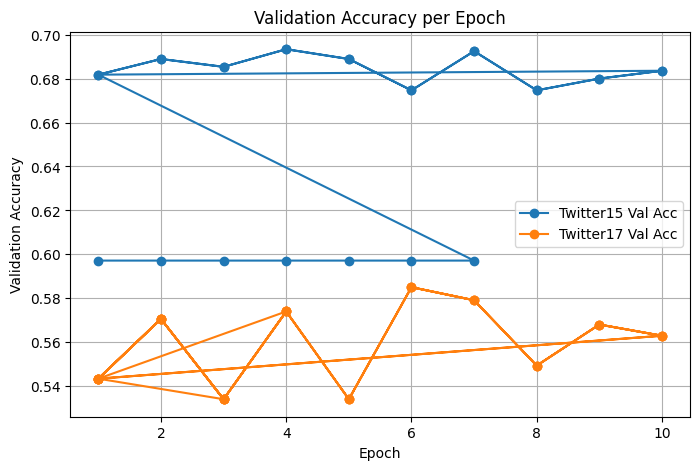

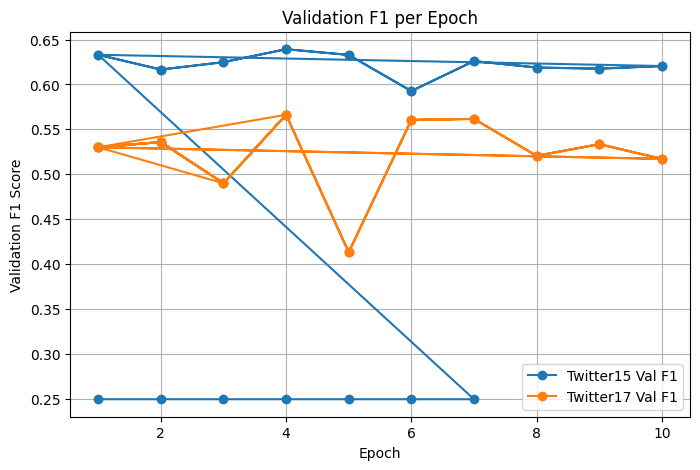

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ✅ Load your log files from Google Drive
t15 = pd.read_csv("/content/drive/MyDrive/MSA/DPFN-main/result/twitter15_training_log.csv")
t17 = pd.read_csv("/content/drive/MyDrive/MSA/DPFN-main/result/twitter17_training_log.csv")

# ============================
# 📈 Validation Accuracy Plot
# ============================
plt.figure(figsize=(8,5))
plt.plot(t15["epoch"], t15["val_acc"], marker='o', label="Twitter15 Val Acc")
plt.plot(t17["epoch"], t17["val_acc"], marker='o', label="Twitter17 Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
plt.title("Validation Accuracy per Epoch")
plt.legend()
plt.grid(True)
plt.show()

# ============================
# 📊 Validation F1 Plot
# ============================
plt.figure(figsize=(8,5))
plt.plot(t15["epoch"], t15["val_f1"], marker='o', label="Twitter15 Val F1")
plt.plot(t17["epoch"], t17["val_f1"], marker='o', label="Twitter17 Val F1")
plt.xlabel("Epoch")
plt.ylabel("Validation F1 Score")
plt.title("Validation F1 per Epoch")
plt.legend()
plt.grid(True)
plt.show()


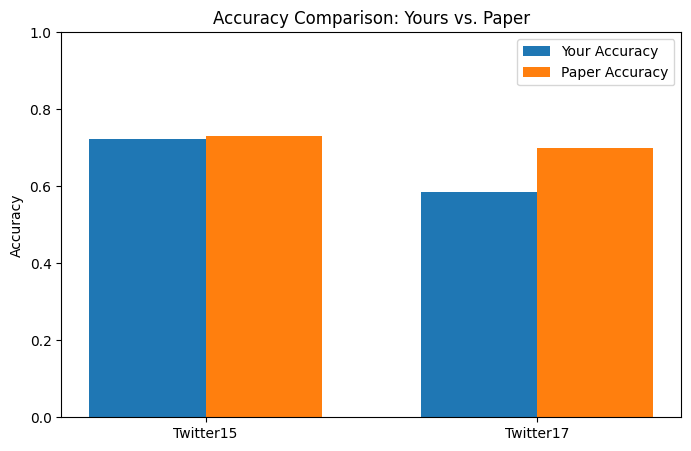

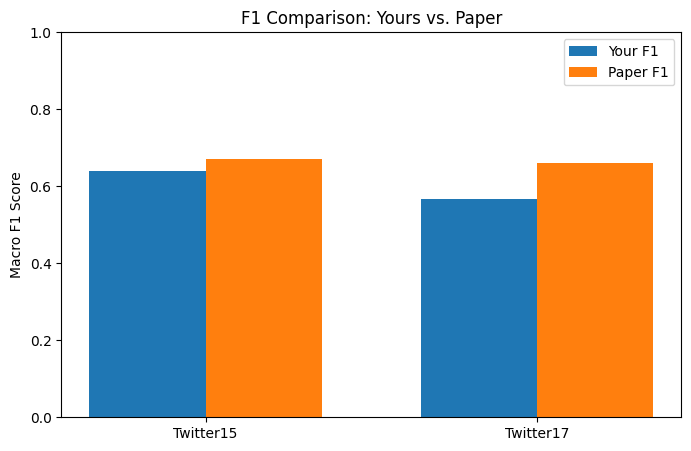

In [ ]:
# Your results (best from training logs)
my_results = {
    "Twitter15": {"Accuracy": 0.724, "F1": 0.639},
    "Twitter17": {"Accuracy": 0.585, "F1": 0.566},
}

# Paper-reported results (from DPFN paper)
paper_results = {
    "Twitter15": {"Accuracy": 0.73, "F1": 0.67},
    "Twitter17": {"Accuracy": 0.70, "F1": 0.66},
}

import numpy as np

datasets = ["Twitter15", "Twitter17"]
x = np.arange(len(datasets))
width = 0.35

plt.figure(figsize=(8,5))
plt.bar(x - width/2, [my_results[d]["Accuracy"] for d in datasets], width, label="Your Accuracy")
plt.bar(x + width/2, [paper_results[d]["Accuracy"] for d in datasets], width, label="Paper Accuracy")
plt.xticks(x, datasets)
plt.ylabel("Accuracy")
plt.title("Accuracy Comparison: Yours vs. Paper")
plt.legend()
plt.ylim(0,1)
plt.show()

plt.figure(figsize=(8,5))
plt.bar(x - width/2, [my_results[d]["F1"] for d in datasets], width, label="Your F1")
plt.bar(x + width/2, [paper_results[d]["F1"] for d in datasets], width, label="Paper F1")
plt.xticks(x, datasets)
plt.ylabel("Macro F1 Score")
plt.title("F1 Comparison: Yours vs. Paper")
plt.legend()
plt.ylim(0,1)
plt.show()
